#  LMS Exploration | 17. KorQuAD_BERT

---

**[Introduce]**  
오늘은 인간보다 퀴즈를 잘 푸는 인공지능을 만들어보겠습니다 ~ 
#### Q. 어떤 퀴즈를 풀건데? 
#### A. KorQuAD

   - SQuAD(Stanford Question Answering Dataset)는 컴퓨터가 사람처럼 주어진 문서를 읽고 이해한 후 질문에 대한 정답을 찾아내는 MRC(Machine Reading Comprehension, 기계 독해 이해력) 테스트의 하나입니다. 
   - 많은 기업들은 미국 스탠퍼드 대학에서 주관하는 기계 독해 경진대회 '스쿼드 2.0'에서 상위 랭킹 순위에 오르기 위해 활발한 연구를 진행중입니다.   
   - 랭킹 순위는 스탠포드 대학에서 제공하는 10만개의 질문과 답으로 구성된 대용량 데이터 세트(SQuAD)를 기반으로 기업, 연구소 등이 보유한 AI의 MRC 성능을 테스트하고 공개됩니다.
   - **우리는 한국형 SQuAD인 KorQuAD 태스크를 수행하는 모델을 학습해보겠습니다!**
       - KorQuAD 2.0은 KorQuAD 1.0에서 질문답변 20,000+ 쌍을 포함하여 총 100,000+ 쌍으로 구성된 한국어 Machine Reading Comprehension 데이터셋 입니다.
       - 자세한 설명은 이후 데이터처리에서 이어집니다!


#### Q. 인간보다 퀴즈를 잘 푸는 인공지능이 있다고?
#### A. BERT
   - 2018년 10월, SQuAD 리더보드에 Human performance를 능가하는 점수로 1위 자리를 갱신한 모델이 나타났습니다.
   - 구글에서 발표한 모델은 바로 **BERT**(Bidirectional Encoder Representations from Transformers)입니다.
   - 이 모델은 340MB나 되는 엄청난 사이즈의 파라미터를 가진 모델을 수십 GB나 되는 코퍼스를 학습 시켜 만든 **pretrained model**로서, SQuAD뿐 아니라 당시 거의 모든 자연어처리 태스크의 SOTA(State-of-the-art)를 갱신했습니다.
   - BERT는 엄청난 규모의 언어 모델(Language Model)을 pretrain하고 이를 어떤 태스크에든 약간의 fine-tuning만을 통해 손쉽게 적용하여 해결하는 **제너럴한 방식**이 가능함을 입증하여, 자연어처리 패러다임의 근본적인 변화를 불러왔습니다.
   - 현재 SQuAD 2.0 랭킹 1위는 RICOH_SRCB_DML의 IE-Net (ensemble)모델(Jun 04, 2021)입니다. 
   - 현재 KorQuAD 2.0 랭킹 1위는 Samsung SDS AI Research의 SDS-NET v1.3 (single model)입니다.


   - **BERT 모델 구조를 살펴보고, Pretrained Model을 활용하여 한국형 SQuAD인 KorQuAD 태스크를 수행하는 모델을 학습해 봅니다!**

**[Preparation]**
- 이번 노드에서 사용할 주요 패키지는 다음과 같습니다.
    - tensorflow_addons
    - sentencepiece
    - wordcloud
    - ipywidgets --user
    - tqdm
    - pydot
    - pydotplus
    - graphviz


In [1]:
! mkdir -p ~/aiffel/bert_qna/data ~/aiffel/bert_qna/models
! ln -s ~/data/data/* ~/aiffel/bert_qna/data
! ln -s ~/data/models/* ~/aiffel/bert_qna/models

ln: failed to create symbolic link '/aiffel/aiffel/bert_qna/data/KorQuAD_v1.0_dev.json': File exists
ln: failed to create symbolic link '/aiffel/aiffel/bert_qna/data/KorQuAD_v1.0_train.json': File exists
ln: failed to create symbolic link '/aiffel/aiffel/bert_qna/data/kowiki.txt.zip': File exists
ln: failed to create symbolic link '/aiffel/aiffel/bert_qna/models/bert_pretrain_32000.hdf5': File exists
ln: failed to create symbolic link '/aiffel/aiffel/bert_qna/models/ko_32000.model': File exists
ln: failed to create symbolic link '/aiffel/aiffel/bert_qna/models/ko_32000.vocab': File exists


```python
#- 한국어 시각화를 위한 패키지
! sudo apt update -qq
! sudo apt install fonts-nanum* -qq
```

In [2]:
#- 한국어 폰트 설치를 확인합니다.  
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()


# Q1. 그래서 KorQuAD Task 가 모야?
- [KorQuAD](https://korquad.github.io/)(The Korean Question Answering Dataset, 한국어 질의응답 데이터셋)을 통해 자연어처리 분야의 기계독해(Machine Reading Comprehension, MRC)  태스크를 수행하는 모델을 만들어봅니다.
- 이 데이터셋은 미국 스탠퍼드 대학에서 구축한 대용량 데이터셋인 SQuAD를 벤치마킹한 것입니다.
- 자연어처리에 입문하게 되면 흔히는 감성분석 등의 Text Classification, 또는 Encoder-Decoder 구조의 모델을 통한 번역 태스크를 많이 다루게 될 것이지만 자연어처리 분야에서 기계독해 태스크는 머신이 자연어의 의미를 정확하게 이해하고 사람의 질문에 정확하게 답변할 수 있는지를 측정하는 아주 중요한 분야입니다.
- 따라서 [SQuAD 데이터셋](https://rajpurkar.github.io/SQuAD-explorer/)은 언어 모델의 성능을 측정하는 가장 표준적인 벤치마크로 인정받고 있음
- 세계 유수 연구소와 대학에서 SQuAD 데이터셋의 리더보드에 이름을 올리기 위해 지금도 열심히 연구중입니다.
- 두 데이터셋 모두 현재는 2.0으로 버전이 올라가 있습니다.
- 버전 1.0과 2.0 모두 EM(Exact Match: 모델이 정답을 정확히 맞춘 비율), F1 score(모델이 낸 답안과 정답이 음절 단위로 겹치는 부분을 고려한 부분점수), 1-example-latency(질문당 응답속도) 이상 3가지 척도로 모델을 평가합니다.
- **KorQuAD는 딥러닝 기반 QA(질의응답), 한국어 독해 능력을 측정하는 가장 중요한 태스크라 할 수 있습니다.**
- 우리는 KorQuAD 1.0 데이터로 실습을 진행해보겠습니다.
- KorQuAD1.0과 2.0의 주요한 차이점 3가지는 다음과 같습니다. 
    - 문서의 길이 : 지문의 길이가 1.0은 한두 문단 정도지만 2.0은 위키백과 한 페이지 분량 
    - 문서의 구조 : 2.0에는 표와 리스트가 포함되어 있어 html 태그를 이해할 수 있어야 함 
    - 답변의 길이와 구조 : 1.0에서는 단어나 구 단위였으나, 2.0에서는 표와 리스트를 포함한 긴 영역의 답변 가능



In [3]:
#- 아이펠 클라우드에 친절히 준비되어있는 KorQuAD, Bert_pretrained model
#- KorQuAD 1.0 데이터와 실험에서 활용할 model, vocab, text corpus 데이터 등을 확인

! ls ~/aiffel/bert_qna/data
! ls ~/aiffel/bert_qna/models 

korquad_dev.json    KorQuAD_v1.0_dev.json    kowiki.txt.zip
korquad_train.json  KorQuAD_v1.0_train.json
bert_pretrain_32000.hdf5  ko_32000.model  ko_32000.vocab


- ko_32000.model
- ko_32000.vocab
- bert_pretrain_32000.hdfs
- kowiki.txt.zip

In [4]:
#- imports
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow_addons as tfa

import os
import re
import numpy as np
import pandas as pd
import pickle
import random
import collections
import json
from datetime import datetime

import sentencepiece as spm
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

In [5]:
#- json 포맷으로 이뤄진 데이터에서 리스트의 첫번째 아이템 실제 내용 확인

def print_json_tree(data, indent=""):
    for key, value in data.items():
        if type(value) == list:     # list 형태의 item은 첫번째 item만 출력
            print(f'{indent}- {key}: [{len(value)}]')
            print_json_tree(value[0], indent + "  ")
        else:
            print(f'{indent}- {key}: {value}')

In [6]:
data_dir = os.getenv('HOME')+'/aiffel/bert_qna/data'
model_dir = os.getenv('HOME')+'/aiffel/bert_qna/models'

#- 훈련데이터 확인
train_json_path = data_dir + '/KorQuAD_v1.0_train.json'
with open(train_json_path) as f:
    train_json = json.load(f)
    print_json_tree(train_json)

- version: KorQuAD_v1.0_train
- data: [1420]
  - paragraphs: [3]
    - qas: [8]
      - answers: [1]
        - text: 교향곡
        - answer_start: 54
      - id: 6566495-0-0
      - question: 바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?
    - context: 1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. 여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 볼 수 있다. 그렇게 교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에 중단했다. 또한 작품의 완성과 동시에 그는 이 서곡(1악장)을 파리 음악원의 연주회에서 연주할 파트보까지 준비하였으나, 실제로는 이루어지지는 않았다. 결국 초연은 4년 반이 지난 후에 드레스덴에서 연주되었고 재연도 이루어졌지만, 이후에 그대로 방치되고 말았다. 그 사이에 그는 리엔치와 방황하는 네덜란드인을 완성하고 탄호이저에도 착수하는 등 분주한 시간을 보냈는데, 그런 바쁜 생활이 이 곡을 잊게 한 것이 아닌가 하는 의견도 있다.
  - title: 파우스트_서곡


In [7]:
#- 검증데이터 확인
dev_json_path = data_dir + '/KorQuAD_v1.0_dev.json'
with open(dev_json_path) as f:
    dev_json = json.load(f)
    print_json_tree(dev_json)

- version: KorQuAD_v1.0_dev
- data: [140]
  - paragraphs: [2]
    - qas: [7]
      - answers: [1]
        - text: 1989년 2월 15일
        - answer_start: 0
      - id: 6548850-0-0
      - question: 임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배 된 날은?
    - context: 1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내려오는 임종석을 발견, 검거해 구속을 집행했다. 임종석은 청량리경찰서에서 약 1시간 동안 조사를 받은 뒤 오전 9시 50분 경 서울 장안동의 서울지방경찰청 공안분실로 인계되었다.
  - title: 임종석


```python
#- JSON 포맷 데이터를 메모리에 만들기
print(json.dumps(train_json["data"][0], indent=2, ensure_ascii=False))
```

- 위 코드를 실행하면 아래와 같은 형식의 JSON 데이터를 출력합니다.
```python
{
  "paragraphs": [
    {
      "qas": [
        {
          "answers": [
            {
              "text": "교향곡", #- 정답텍스트
              "answer_start": 54 #- 정답텍스트 시작위치
            }
          ],
          "id": "6566495-0-0", #- 질문아이디
          "question": "바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?" #- 질문텍스트
        },
      ... 중략 ...
        {
          "answers": [
            {
              "text": "드레스덴",
              "answer_start": 534
            }
          ],
          "id": "5917067-0-2",
          "question": "바그너의 1악장의 초연은 어디서 연주되었는가?"
        }
      ], #- 지문
      "context": "1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. 여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 볼 수 있다. 그렇게 교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에 중단했다. 또한 작품의 완성과 동시에 그는 이 서곡(1악장)을 파리 음악원의 연주회에서 연주할 파트보까지 준비하였으나, 실제로는 이루어지지는 않았다. 결국 초연은 4년 반이 지난 후에 드레스덴에서 연주되었고 재연도 이루어졌지만, 이후에 그대로 방치되고 말았다. 그 사이에 그는 리엔치와 방황하는 네덜란드인을 완성하고 탄호이저에도 착수하는 등 분주한 시간을 보냈는데, 그런 바쁜 생활이 이 곡을 잊게 한 것이 아닌가 하는 의견도 있다."
    },
      ... 
```

# Q2. KorQuAD 데이터 전처리는 어떻게 해야해?
- SQuAD, KorQuAD 데이터셋으로 모델을 구성하기 위한 전처리 과정은 다른 자연어처리 태스크와 다소 다른 접근이 필요합니다.
- 아래의 순서로 차근차근 전처리를 수행해봅니다.
  1. 띄어쓰기 단위 정보관리
  2. Tokenize by Vocab
  3. Improve Span
  4. 데이터셋 분리
  5. 데이터셋 분석 

## (1) 띄어쓰기 단위 정보관리
- c 는 character(문자)로 입력문장(문자열)의 요소를 하나씩 불러온 것입니다. 한국어 문장에서 '음절'을 의미합니다. 음절은 한번에 소리낼 수 있는 소리마디로 '아침'은 '아','침'으로 나눌 수 있습니다. (엄밀히 말하면 character에는 음절뿐만 아니라 공백, 문장부호 등이 포함됩니다.) 
- whitespace(공백)를 기준으로 문장을 나누면(tokenize, 토큰화), 한국어 문장에서 '어절'을 의미합니다. 어절은 문장을 구성하고 있는 각각의 마디로, 문장 성분의 최소 단위로서 띄어쓰기 단위가 됩니다. '아침이 밝았다.'는 '아침이','밝았다.'로 나눌 수 있습니다.
- 우리는 어절 단위로 문장을 나누고, 각 음절마다 띄어쓰기 단위 정보를 저장해보겠습니다. 
- 이렇게 하는 이유는, **SQuAD 유형의 문제를 풀 때 글자 혹은 subword 단위로 token이 분리되는 것에 대비해서, 원래 데이터가 띄어쓰기 단위로 어떠했었는지 word token 영역별로 추가 정보를 관리하면 도움이 되기 때문입니다.**

In [9]:
def _is_whitespace(c): #- 공백여부를 반환하는 함수
    if c == " " or c == "\t" or c == "\r" or c == "\n" or ord(c) == 0x202F:
        return True
    return False

In [10]:
#- 공백(whitespace)이 2개인 경우를 처리해야 합니다.

string1 = '1839년 파우스트를 읽었다.' #- 공백이 1개
string2 = '1839년  파우스트를 읽었다.' #- 공백이 2개
string1[6:10], string2[7:11]

('파우스트', '파우스트')

In [11]:
#- 두 문장에 대해 글자별 띄어쓰기 영역 정보 관리

word_tokens = [] 
char_to_word = [] #- character to word
prev_is_whitespace = True #- 이전글자가 공백인지 여부

#- 첫번째 문장(string1)에 대해 띄어쓰기 영역 정보 표시

for c in string1: #- 반복문을 통해 문장 string1 을 구성하는 character를 하나씩 호출
    if _is_whitespace(c): #- 만약 character가 공백이라면,
        prev_is_whitespace = True #- prev_is_whitespace에 True를 할당
    else: #- 만약 character가 공백이 아닌데,
        if prev_is_whitespace: #- prev_is_whitespace가 참인경우(T/F)
            word_tokens.append(c) #- word_tokens에 c를 추가
        else: #- 만약 character가 공백이 아닌데, prev_is_whitespace가 거짓인 경우(F/F)
            word_tokens[-1] += c #- word_tokens의 마지막 token 안에 c를 추가
        prev_is_whitespace = False #- 만약 character가 공백이 아니라면, prev_is_whitespace에 False 할당
    char_to_word.append(len(word_tokens)-1) #- char_to_word에 (len(word_tokens)-1)을 추가
    print(f'\'{c}\':{word_tokens}:{char_to_word}')

'1':['1']:[0]
'8':['18']:[0, 0]
'3':['183']:[0, 0, 0]
'9':['1839']:[0, 0, 0, 0]
'년':['1839년']:[0, 0, 0, 0, 0]
' ':['1839년']:[0, 0, 0, 0, 0, 0]
'파':['1839년', '파']:[0, 0, 0, 0, 0, 0, 1]
'우':['1839년', '파우']:[0, 0, 0, 0, 0, 0, 1, 1]
'스':['1839년', '파우스']:[0, 0, 0, 0, 0, 0, 1, 1, 1]
'트':['1839년', '파우스트']:[0, 0, 0, 0, 0, 0, 1, 1, 1, 1]
'를':['1839년', '파우스트를']:[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
' ':['1839년', '파우스트를']:[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]
'읽':['1839년', '파우스트를', '읽']:[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2]
'었':['1839년', '파우스트를', '읽었']:[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2]
'다':['1839년', '파우스트를', '읽었다']:[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2]
'.':['1839년', '파우스트를', '읽었다.']:[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2]


- 정리하면, 띄어쓰기 단위로 token을 나누어 word_tokens 리스트에 저장하고, 띄어쓰기 단위의 정보를 관리하는 char_to_word 리스트를 만드는 것입니다. 
- char_to_word는 띄어쓰기를 경계로 token을 그룹화하여 각 character 마다 index를 부여한다고 이해할 수 있습니다. 이때 공백은 앞쪽 token의 그룹에 포함됩니다. 이 값은 현재 글자가 몇 번째 어절에 포함된 것이었는지를 말해줍니다.  
- 그렇다면 공백이 2칸인 경우엔 char_to_word 리스트가 어떻게 형성될까요? 어렵지 않습니다 ~

In [12]:
word_tokens = []
char_to_word = []
prev_is_whitespace = True

# 두번째 문장(string2)에 대해 띄어쓰기 영역 정보를 표시
for c in string2:
    if _is_whitespace(c):
        prev_is_whitespace = True
    else:
        if prev_is_whitespace:
            word_tokens.append(c)
        else:
            word_tokens[-1] += c
        prev_is_whitespace = False    
    char_to_word.append(len(word_tokens) - 1)
    print(f'\'{c}\' : {word_tokens} : {char_to_word}')

'1' : ['1'] : [0]
'8' : ['18'] : [0, 0]
'3' : ['183'] : [0, 0, 0]
'9' : ['1839'] : [0, 0, 0, 0]
'년' : ['1839년'] : [0, 0, 0, 0, 0]
' ' : ['1839년'] : [0, 0, 0, 0, 0, 0]
' ' : ['1839년'] : [0, 0, 0, 0, 0, 0, 0]
'파' : ['1839년', '파'] : [0, 0, 0, 0, 0, 0, 0, 1]
'우' : ['1839년', '파우'] : [0, 0, 0, 0, 0, 0, 0, 1, 1]
'스' : ['1839년', '파우스'] : [0, 0, 0, 0, 0, 0, 0, 1, 1, 1]
'트' : ['1839년', '파우스트'] : [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]
'를' : ['1839년', '파우스트를'] : [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
' ' : ['1839년', '파우스트를'] : [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]
'읽' : ['1839년', '파우스트를', '읽'] : [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2]
'었' : ['1839년', '파우스트를', '읽었'] : [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2]
'다' : ['1839년', '파우스트를', '읽었다'] : [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2]
'.' : ['1839년', '파우스트를', '읽었다.'] : [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2]


- 위에서 진행한 과정을 토대로 '띄어쓰기 단위정보관리' 함수를 만들어봅니다. 

In [13]:
#- 공백을 토큰화하는 함수
def _tokenize_whitespace(string):
    word_tokens = []
    char_to_word = []
    prev_is_whitespace = True

    for c in string: 
        if _is_whitespace(c):
            prev_is_whitespace = True
        else:
            if prev_is_whitespace:
                word_tokens.append(c)
            else:
                word_tokens[-1] += c
            prev_is_whitespace = False    
        char_to_word.append(len(word_tokens) - 1)
    
    return word_tokens, char_to_word

- string1, string2를 입력으로 하여 함수가 잘 작동하는지 확인해봅니다.

In [14]:
# 첫번째 문장(string1)에 대해 띄어쓰기 영역 정보를 표시
word_tokens, char_to_word = _tokenize_whitespace(string1)
for c, i in zip(list(string1), char_to_word):
    print(f'\'{c}\' : {i}')

word_tokens, char_to_word

'1' : 0
'8' : 0
'3' : 0
'9' : 0
'년' : 0
' ' : 0
'파' : 1
'우' : 1
'스' : 1
'트' : 1
'를' : 1
' ' : 1
'읽' : 2
'었' : 2
'다' : 2
'.' : 2


(['1839년', '파우스트를', '읽었다.'], [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2])

In [15]:
# 두번째 문장(string2)에 대해 띄어쓰기 영역 정보를 표시
word_tokens, char_to_word = _tokenize_whitespace(string2)
for c, i in zip(list(string2), char_to_word):
    print(f'\'{c}\' : {i}')

word_tokens, char_to_word

'1' : 0
'8' : 0
'3' : 0
'9' : 0
'년' : 0
' ' : 0
' ' : 0
'파' : 1
'우' : 1
'스' : 1
'트' : 1
'를' : 1
' ' : 1
'읽' : 2
'었' : 2
'다' : 2
'.' : 2


(['1839년', '파우스트를', '읽었다.'],
 [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2])

### Q. 그래서 _tokenize_whitespace 함수가 뭐라구요?
- _tokenize_whitespace 함수는 'word_tokens'와 'char_to_word'를 반환합니다. 
    - word_tokens : 문자열입력을 띄어쓰기 단위로 토큰화한 결과(어절)를 저장하는 리스트입니다.
    - char_to_word : 띄어쓰기를 경계로 각 character(음절)를 그룹화하여 각 character(공백,음절,문장부호)마다 index를 부여하여 띄어쓰기 정보를 나타내는 리스트입니다. 이 값은 현재 글자가 몇 번째 어절에 포함된 것이었는지를 말해줍니다.

## (2) Tokenize by Vocab
- 이 모~든 단어를 전부 단어사전에 추가하려면 너무 많은 단어가 필요할 것입니다. 이것이 바로 Word 기반의 단어사전 구축이 가지는 문제점입니다. 특히 한국어의 경우엔 이러한 문제점이 심각할 것입니다. 
- 따라서 **Subword Segmentation** 접근법이 있습니다. 예를 들어 '먹는다'를 '먹'+'는다'로 나눠 처리하는 것입니다. 
- BERT에는 [WordPiece](https://arxiv.org/pdf/1609.08144.pdf) 모델 사용이 일반적이지만, **우리는 [SentencePiece](https://github.com/google/sentencepiece)모델을 이용해서 Subword기반의 텍스트 전처리를 진행해보겠습니다.**
- 구글에서 오픈소스로 제공하는 SentencePiece 모델은 파이썬에서 손쉽게 사용이 가능하며, WordPiece 등 다른 모델들을 통합하여 제공하므로 최근 널리 사용되고 있습니다. 
- 한국어의 경우에는 koNLPy를 통해 사용할 수 있는 형태소분석기가 Subword Segmentation의 역할을 합니다. 
- **SentencePiece 같은 모델들은 언어마다 다른 문법규칙을 활용하지 않고, 적절한 Subword 분절 규칙을 학습하거나, 혹은 자주 사용되는 구문을 하나의 단어로 묶어내는 등 통계적인 방법을 사용합니다. 때문에, 어떤 언어에든 보편적으로 적용이 가능하다는 장점이 있습니다.** 

In [16]:
# vocab loading
vocab = spm.SentencePieceProcessor()
vocab.load(f"{model_dir}/ko_32000.model")

# word를 subword로 변경하면서 index 저장
word_to_token = []
context_tokens = []
for (i, word) in enumerate(word_tokens): #- word_tokens는 문장의 어절단위로 나눈 token 리스트
    word_to_token.append(len(context_tokens))
    tokens = vocab.encode_as_pieces(word)  # SentencePiece를 사용해 Subword로 쪼갭니다.
    for token in tokens:
        context_tokens.append(token) 

context_tokens, word_to_token

(['▁1839', '년', '▁', '파우스트', '를', '▁읽', '었다', '.'], [0, 2, 5])

- '_' 표시는 앞부분이 공백이라는 의미입니다.
- word_to_token의 [0, 2, 5]란 context_tokens에 쪼개져 담긴 0번, 2번, 5번 토큰인 '▁1839', '▁', '▁읽' 이 어절단위의 첫번째 토큰이 된다는 정보를 담아둔 것입니다.
- SentencePiece를 활용하는 코드를 **_tokenize_vocab** 함수로 만듭니다.

In [17]:
def _tokenize_vocab(vocab, context_words):
    word_to_token = []
    context_tokens = []
    for (i, word) in enumerate(context_words):
        word_to_token.append(len(context_tokens))
        tokens = vocab.encode_as_pieces(word)
        for token in tokens:
            context_tokens.append(token)
    return context_tokens, word_to_token

In [18]:
print(word_tokens) #- 처리해야 할 word 단위 입력

context_tokens, word_to_token = _tokenize_vocab(vocab, word_tokens)
context_tokens, word_to_token #- Subword 단위로 토큰화한 결과

['1839년', '파우스트를', '읽었다.']


(['▁1839', '년', '▁', '파우스트', '를', '▁읽', '었다', '.'], [0, 2, 5])

###  Q. 그래서 _tokenize_vocab 함수가 뭐라구요?
- _tokenize_vocab 은 SentencePiece model에서 로드한 vocab 과 어절단위 토큰리스트를 입력으로 받아서 context_tokens와 word_to_token를 반환합니다. 
    - context_tokens : subword 단위 토큰 리스트
    - word_to_token : 어절단위 첫번째 토큰에 해당하는 context_tokens의 인덱스 리스트. 

## (3) Improve Span   
- KorQuAD 데이터셋에서 context, question, answer를 뽑아 봅니다.
- KorQuAD 데이터셋은 질문(question)과 지문(context)을 주고, 지문 영역에서 정답(answer)을 찾도록 구성되어 있습니다. 
- 따라서 **정답에 해당하는 지문 영역을 정확히 찾아내는 것이 전처리의 핵심 작업이 됩니다.**
- 참고로, 파이썬 Assertion 구문은 어떤 조건을 테스트하는 디버깅 보조 도구입니다. 이 구문은 예상하지 않은 프로그램의 상태를 확인하기 위해 활용해야 합니다. 구문의 조건을 만족하지 않으면 프로그램이 정상적으로 실행되지 않고 종료되는데, 이는 프로그램의 버그가 있다는 것을 의미합니다.

In [19]:
context = train_json['data'][0]['paragraphs'][0]['context']
question = train_json['data'][0]['paragraphs'][0]['qas'][0]['question']
answer_text = train_json['data'][0]['paragraphs'][0]['qas'][0]['answers'][0]['text']
answer_start = train_json['data'][0]['paragraphs'][0]['qas'][0]['answers'][0]['answer_start']
answer_end = answer_start + len(answer_text) - 1 #- 데이터셋에서 제공하는 answer_start를 활용해 answer_end의 index를 설정합니다.

print('[context] ', context)
print('[question] ', question)
print('[answer] ', answer_text)
print('[answer_start] index: ', answer_start, 'character: ', context[answer_start])
print('[answer_end]index: ', answer_end, 'character: ', context[answer_end])

# answer_text에 해당하는 context 영역을 정확히 찾아내야 합니다. 
assert context[answer_start:answer_end + 1] == answer_text

[context]  1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. 여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 볼 수 있다. 그렇게 교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에 중단했다. 또한 작품의 완성과 동시에 그는 이 서곡(1악장)을 파리 음악원의 연주회에서 연주할 파트보까지 준비하였으나, 실제로는 이루어지지는 않았다. 결국 초연은 4년 반이 지난 후에 드레스덴에서 연주되었고 재연도 이루어졌지만, 이후에 그대로 방치되고 말았다. 그 사이에 그는 리엔치와 방황하는 네덜란드인을 완성하고 탄호이저에도 착수하는 등 분주한 시간을 보냈는데, 그런 바쁜 생활이 이 곡을 잊게 한 것이 아닌가 하는 의견도 있다.
[question]  바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?
[answer]  교향곡
[answer_start] index:  54 character:  교
[answer_end]index:  56 character:  곡


In [20]:
#- context를 띄어쓰기(word)단위로 토큰화한 결과를 살펴봅니다.
word_tokens, char_to_word = _tokenize_whitespace(context)

print(word_tokens[:20])

char_to_word[:20], context[:20]

['1839년', '바그너는', '괴테의', '파우스트을', '처음', '읽고', '그', '내용에', '마음이', '끌려', '이를', '소재로', '해서', '하나의', '교향곡을', '쓰려는', '뜻을', '갖는다.', '이', '시기']


([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3],
 '1839년 바그너는 괴테의 파우스트을')

In [21]:
# 띄어쓰기(word) 단위로 쪼개진 context(word_tokens)를 Subword로 토큰화한 결과를 살펴봅니다. 
context_tokens, word_to_token = _tokenize_vocab(vocab, word_tokens)
for i in range(min(20, len(word_to_token) - 1)):
    print(word_to_token[i], context_tokens[word_to_token[i]:word_to_token[i + 1]])

0 ['▁1839', '년']
2 ['▁바그너', '는']
4 ['▁괴테', '의']
6 ['▁', '파우스트', '을']
9 ['▁처음']
10 ['▁읽고']
11 ['▁그']
12 ['▁내용에']
13 ['▁마음이']
14 ['▁끌려']
15 ['▁이를']
16 ['▁소재로']
17 ['▁해서']
18 ['▁하나의']
19 ['▁교향곡', '을']
21 ['▁쓰', '려는']
23 ['▁뜻을']
24 ['▁갖는다', '.']
26 ['▁이']
27 ['▁시기']


- 위에서 context에 포함된 answer의 글자단위 시작 인덱스 answer_start와 종료 인덱스 answer_end를 구했습니다. 이 위치를 어절(word)단위로 변환하면 어떻게 될까요? 

In [22]:
#- answer_start 와 answer_end로부터 word_start와 word_end를 구합니다.
word_start = char_to_word[answer_start]
word_end = char_to_word[answer_end]
word_start, word_end, answer_text, word_tokens[word_start:word_end + 1]

(14, 14, '교향곡', ['교향곡을'])

- answer_start와 answer_end는 subword tokenize 결과인 context_tokens의 위치인덱스를 따릅니다. 공백은 단어앞에 붙거나, 하나의 subword로 해석됩니다. 
- word_start와 word_end는 띄어쓰기단위 tokenize에 따라 현재 글자가 몇 번째 어절에 포함되었는지를 알려주는 char_to_word의 위치인덱스를 따릅니다. char_to_word에서는 공백은 어절 뒤에 포함됩니다. 
- 우리가 찾는 정답은 15번째 어절(index=14)에 있었습니다.
- 하지만 우리가 원하는 정답은 "교향곡을" 이 아닌 "교향곡" 입니다.
- 그래서 이번에는 word_start 로부터 word_end 까지의 context를 Subword단위로 토큰화한 결과를 살펴봅니다. 

In [23]:
token_start = word_to_token[word_start] #- word_to_token의 word_start 번째 요소는, word_start번째 어절에 포함된 첫번째 subword token입니다.  
if word_end < len(word_to_token) - 1: 
    token_end = word_to_token[word_end + 1] - 1 
else:
    token_end = len(context_tokens) - 1
    
token_start, token_end, context_tokens[token_start:token_end + 1]

(19, 20, ['▁교향곡', '을'])

In [24]:
# 실제 정답인 answer_text도 Subword 기준으로 토큰화해 둡니다. 
token_answer = " ".join(vocab.encode_as_pieces(answer_text))
token_answer

'▁교향곡'

- 좀더 일반적인 방법으로 정답 토큰 범위를 찾는 코드를 작성해봅니다. 
- KorQuAD 문제의 정답은 단답형만 있는 것은 아니기 때문에 일반화 과정이 필수적입니다.

In [25]:
# 정답이 될수 있는 new_start와 new_end의 경우를 순회탐색합니다. 
for new_start in range(token_start, token_end + 1):
    for new_end in range(token_end, new_start - 1, -1):
        text_span = " ".join(context_tokens[new_start : (new_end + 1)])
        if text_span == token_answer:   # 정답과 일치하는 경우
            print("O >>", (new_start, new_end), text_span)
        else:
            print("X >>", (new_start, new_end), text_span)

X >> (19, 20) ▁교향곡 을
O >> (19, 19) ▁교향곡
X >> (20, 20) 을


-  context에서 answer의 위치를 토큰화된 상태에서 찾는 함수 _improve_span를 생성합니다.

In [26]:
# context_tokens에서 char_answer의 위치를 찾아 리턴하는 함수
def _improve_span(vocab, context_tokens, token_start, token_end, char_answer):
    token_answer = " ".join(vocab.encode_as_pieces(char_answer))
    for new_start in range(token_start, token_end + 1):
        for new_end in range(token_end, new_start - 1, -1):
            text_span = " ".join(context_tokens[new_start : (new_end + 1)])
            if text_span == token_answer:
                return (new_start, new_end)
            
    return (token_start, token_end)

In [27]:
token_start, token_end = _improve_span(vocab, context_tokens, token_start, token_end, answer_text)
print('token_start:', token_start, ' token_end:', token_end)
context_tokens[token_start:token_end + 1]

token_start: 19  token_end: 19


['▁교향곡']

###  Q. 그래서 _improve_span 함수가 뭐라구요?
- _improve_span 은 vocab, context_tokens, token_start, token_end, char_answer을 입력인자로 받아서, (new_start, new_end)를 반환합니다. 


## (4) 데이터셋 분리
- train 데이터셋, dev 데이터셋을 분리하여, 위에서 작성한 _improve_span() 함수를 이용해 전처리 후 파일로 저장합니다.



In [28]:
def dump_korquad(vocab, json_data, out_file):
    with open(out_file, "w") as f:
        for data in tqdm(json_data["data"]):
            title = data["title"]
            for paragraph in data["paragraphs"]:
                context = paragraph["context"]
                context_words, char_to_word = _tokenize_whitespace(context)

                for qa in paragraph["qas"]:
                    assert len(qa["answers"]) == 1
                    qa_id = qa["id"]
                    question = qa["question"]
                    answer_text = qa["answers"][0]["text"]
                    answer_start = qa["answers"][0]["answer_start"]
                    answer_end = answer_start + len(answer_text) - 1

                    assert answer_text == context[answer_start:answer_end + 1]

                    word_start = char_to_word[answer_start]
                    word_end = char_to_word[answer_end]

                    word_answer = " ".join(context_words[word_start:word_end + 1])
                    char_answer = " ".join(answer_text.strip().split())
                    assert char_answer in word_answer

                    context_tokens, word_to_token = _tokenize_vocab(vocab, context_words)

                    token_start = word_to_token[word_start]
                    if word_end < len(word_to_token) - 1:
                        token_end = word_to_token[word_end + 1] - 1
                    else:
                        token_end = len(context_tokens) - 1

                    token_start, token_end = _improve_span(vocab, context_tokens, token_start, token_end, char_answer)

                    data = {"qa_id": qa_id, "title": title, "question": vocab.encode_as_pieces(question), "context": context_tokens, "answer": char_answer, "token_start": token_start, "token_end":token_end}
                    f.write(json.dumps(data, ensure_ascii=False))
                    f.write("\n")

In [29]:
# 전처리를 수행하여 파일로 생성합니다. 
dump_korquad(vocab, train_json, f"{data_dir}/korquad_train.json")
dump_korquad(vocab, dev_json, f"{data_dir}/korquad_dev.json")

  0%|          | 0/1420 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

In [111]:
def print_file(filename, count=10):
    """
    파일 내용 출력
    :param filename: 파일 이름
    :param count: 출력 라인 수
    """
    with open(filename) as f:
        for i, line in enumerate(f):
            if count <= i:
                break
            print(line.strip())

# print_file(f"{data_dir}/korquad_train.json")

- print_file 함수 실행 결과 맛보기
```python
{"qa_id": "6566495-0-0", "title": "파우스트_서곡", "question": ["▁바그너", "는", "▁괴테", "의", "▁", "파우스트", "를", "▁읽고", "▁무엇을", "▁쓰고", "자", "▁", "했", "는", "가", "?"], "context": ["▁1839", "년", "▁바그너", "는", "▁괴테", "의", "▁", "파우스트", "을", "▁처음", "▁읽고", "▁그", "▁내용에", "▁마음이", "▁끌려", "▁이를", "▁소재로", "▁해서", "▁하나의", "▁교향곡", "을", "▁쓰", "려는", "▁뜻을", "▁갖는다", ".", "▁이", "▁시기", "▁바그너", "는", "▁1838", "년에", "▁빛", "▁독", "촉", "으로", "▁산", "전", "수", "전을", "▁다", "▁", "걲", "은", "▁상황이", "라", "▁좌절", "과", "▁실망", "에", "▁가득", "했으며", "▁메", "피스", "토", "펠", "레스", "를", "▁만나는", "▁", "파우스트", "의", "▁심", "경에", "▁공감", "했다고", "▁한다", ".", "▁또한", "▁파리에서", "▁아브", "네", "크의", "▁지휘", "로", "▁파리", "▁음악원", "▁관현악단", "이", "▁연주하는", "▁베토벤", "의", "▁교향곡", "▁9", "번을", "▁듣고", "▁깊은", "▁감", "명을", "▁받았는데", ",", "▁이것이", "▁이듬해", "▁1", "월에", "▁", "파우스트", "의", "▁서", "곡으로", "▁쓰여진", "▁이", "▁작품에", "▁조금", "이라도", "▁영향을", "▁끼", "쳤", "으리라", "는", "▁것은", "▁의심", "할", "▁여지가", "▁없다", ".", "▁여기", "의", "▁라", "단", "조", "▁조성", "의", "▁경우에도", "▁그의", "▁전기", "에", "▁적혀", "▁있는", "▁것처럼", "▁단순한", "▁정신적", "▁피로", "나", "▁실", "의", "가", "▁반영", "된", "▁것이", "▁아니라", "▁베토벤", "의", "▁합창", "교", "향", "곡", "▁조성", "의", "▁영향을", "▁받은", "▁것을", "▁볼", "▁수", "▁있다", ".", "▁그렇게", "▁교향곡", "▁작곡", "을", "▁1839", "년부터", "▁40", "년에", "▁걸쳐", "▁파리에서", "▁착수", "했으나", "▁1", "악장", "을", "▁쓴", "▁뒤에", "▁중단", "했다", ".", "▁또한", "▁작품의", "▁완성", "과", "▁동시에", "▁그는", "▁이", "▁서", "곡", "(1", "악장", ")", "을", "▁파리", "▁음악원", "의", "▁연주회", "에서", "▁연주", "할", "▁파트", "보", "까지", "▁준비", "하였으나", ",", "▁실제로는", "▁이루어지지", "는", "▁않았다", ".", "▁결국", "▁초연", "은", "▁4", "년", "▁반", "이", "▁지난", "▁후에", "▁드레스덴", "에서", "▁연주", "되었고", "▁재", "연", "도", "▁이루어졌", "지만", ",", "▁이후에", "▁그대로", "▁방치", "되고", "▁말았다", ".", "▁그", "▁사이에", "▁그는", "▁리", "엔", "치", "와", "▁방", "황", "하는", "▁네덜란드", "인", "을", "▁완성", "하고", "▁탄", "호", "이", "저", "에도", "▁착수", "하는", "▁등", "▁분", "주", "한", "▁시간을", "▁보", "냈는데", ",", "▁그런", "▁바쁜", "▁생활", "이", "▁이", "▁곡을", "▁잊", "게", "▁한", "▁것이", "▁아닌", "가", "▁하는", "▁의견도", "▁있다", "."], "answer": "교향곡", "token_start": 19, "token_end": 19}
... 생략 
```


## (5) 데이터 분석 
- 원본 데이터셋을 전처리하여 우리의 모델이 다루게 될 데이터셋으로 가공하는 과정을 진행하였는데, 이 데이터셋을 그대로 사용할 수 있는지, 이상(abnormal)데이터가 존재하지는 않는지 분석하는 과정이 필요합니다. 
- Question, Context의 길이분포와 Answer의 위치분포를 히스토그램, 사분위수, 박스플롯을 활용하여 분석해봅니다.
- 마지막으로 워드 클라우드(Word Cloud)로 자료의 빈도수를 시각화하여 나타내봅니다.


### Q. 박스플롯이란?

- '박스 플롯'은 '상자 수염 그림'(Box-and-Whisker Plot) '상자 그림' 등 다양한 이름으로 불립니다.
- 많은 데이터를 눈으로 확인하기 어려울 때, 그림으로 데이터 집합의 범위와 중앙값을 빠르게 확인할 수 있고, 통계적으로 이상치(outlier)의 확인이 가능합니다.
- 박스 플롯은 수치적 자료를 표현하는 그래프로, 자료에서 얻은 다섯 수치 요약을 가지고 그립니다.
    - 최솟값 : 제 1사분위에서 1.5 IQR1을 뺀 위치이다.
    - 제 1사분위(Q1) : 25%의 위치를 의미한다.
    - 제 2사분위(Q2) : 50%의 위치로 중앙값(median)을 의미한다.
    - 제 3사분위(Q3) : 75%의 위치를 의미한다.
    - 최댓값 : 제 3사분위에서 1.5 IQR을 더한 위치이다. 
    - 사분위수범위(IQR, interquartile range) : 제 3사분위수와 제 1분위수 사이의 거리, IQR = Q3 - Q1 , IQR은 상위 25%와 하위 25%의 관측값을 제외한 중앙에 위치한 50%의 관측값의 퍼진 정도를 나타내기 떄문에 극단값에 영향을 받지 않는다.
    
    
- 박스플롯을 그리는 방법은 아래와 같습니다.
    - 주어진 데이터에서 각 사분위수를 계산한다.
    - 그래프에서 제 1사분위수와 제 3사분위수를 기준으로 박스를 그린다.
    - 제 2사분위수에 해당하는 위치에 선을 긎는다.
    - 제 3사분위수에서 1.5IQR을 더한 위치에 가로 선을 긎고 제 3사분위수부터 가로선까지 세로선을 긎는다.
    - 제 1사분위수에서 1.5IQR을 뺀 위치에 가로 선을 긎고 제 1사분위수부터 가로선까지 세로선을 긎는다.
    - 4,5번에 그은 직선을 넘어서는 위치에 존재하는 값은 동그라미와 같은 기호로 표시한다.(이상치 의미) 


## 5-1. Question
- train_question_counts은 SentencePiece Tokenized 가 적용된 각 질문문장의 token 개수 정보(문장길이)를 담은 리스트입니다.
- train_question_counts를 활용해 길이분포를 분석합니다.

In [31]:
questions = []
contexts = []
token_starts = []
with open(f"{data_dir}/korquad_train.json") as f:
    for i, line in enumerate(f):
        data = json.loads(line)
        questions.append(data["question"])
        contexts.append(data["context"])
        token_starts.append(data["token_start"])
        if i < 10:
            print(data["token_start"], data["question"])

19 ['▁바그너', '는', '▁괴테', '의', '▁', '파우스트', '를', '▁읽고', '▁무엇을', '▁쓰고', '자', '▁', '했', '는', '가', '?']
168 ['▁바그너', '는', '▁교향곡', '▁작곡', '을', '▁어디', '까지', '▁쓴', '▁뒤에', '▁중단', '했', '는', '가', '?']
80 ['▁바그너', '가', '▁', '파우스트', '▁서', '곡을', '▁쓸', '▁때', '▁어떤', '▁곡', '의', '▁영향을', '▁받았', '는', '가', '?']
6 ['▁1839', '년', '▁바그너', '가', '▁교향곡', '의', '▁소재로', '▁쓰', '려고', '▁했던', '▁책은', '?']
143 ['▁', '파우스트', '▁서', '곡', '의', '▁라', '단', '조', '▁조성', '이', '▁영향을', '▁받은', '▁베토벤', '의', '▁곡은', '?']
0 ['▁바그너', '가', '▁', '파우스트', '를', '▁처음으로', '▁읽', '은', '▁', '년', '도', '는', '?']
165 ['▁바그너', '가', '▁처음', '▁교향곡', '▁작곡', '을', '▁한', '▁장소', '는', '?']
216 ['▁바그너', '의', '▁1', '악장', '의', '▁초연', '은', '▁어디서', '▁연주', '되었', '는', '가', '?']
164 ['▁바그너', '의', '▁작품을', '▁시인', '의', '▁피로', '▁쓰여', '졌다', '고', '▁극찬', '한', '▁것은', '▁누구', '인', '가', '?']
7 ['▁잊', '혀', '져', '▁있는', '▁', '파우스트', '▁서', '곡', '▁1', '악장', '을', '▁부활', '시킨', '▁것은', '▁누구', '인', '가', '?']


In [32]:
# token count
train_question_counts = [len(question) for question in questions]
train_question_counts[:10]

[16, 14, 16, 12, 16, 13, 10, 13, 16, 18]

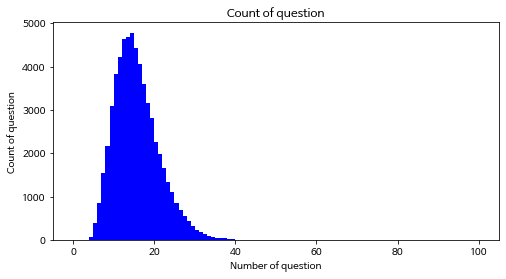

In [33]:
# 그래프에 대한 이미지 사이즈 선언
# figsize: (가로, 세로) 형태의 튜플로 입력
plt.figure(figsize=(8, 4))
# histogram 선언
# bins: 히스토그램 값들에 대한 버켓 범위, 
# range: x축 값의 범위
# facecolor: 그래프 색상
# label: 그래프에 대한 라벨
plt.hist(train_question_counts, bins=100, range=[0, 100], facecolor='b', label='train')
# 그래프 제목
plt.title('Count of question')
# 그래프 x 축 라벨
plt.xlabel('Number of question')
# 그래프 y 축 라벨
plt.ylabel('Count of question')
plt.show()

In [34]:
# 데이터 길이
print(f"question 길이 최대:    {np.max(train_question_counts):4d}")
print(f"question 길이 최소:    {np.min(train_question_counts):4d}")
print(f"question 길이 평균:    {np.mean(train_question_counts):7.2f}")
print(f"question 길이 표준편차: {np.std(train_question_counts):7.2f}")
# 백분위수(Percentile)는 크기가 있는 값들로 이뤄진 자료를 순서대로 나열했을 때 백분율로 나타낸 특정 위치의 값을 이르는 용어이다.
# 일반적으로 크기가 작은 것부터 나열하여 가장 작은 것을 0, 가장 큰 것을 100으로 한다.
# 100개의 값을 가진 어떤 자료의 20 백분위수는 그 자료의 값들 중 20번째로 작은 값을 뜻한다. 50 백분위수는 중앙값과 같다.
percentile25 = np.percentile(train_question_counts, 25)
percentile50 = np.percentile(train_question_counts, 50)
percentile75 = np.percentile(train_question_counts, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"question 25/100분위:  {percentile25:7.2f}")
print(f"question 50/100분위:  {percentile50:7.2f}")
print(f"question 75/100분위:  {percentile75:7.2f}")
print(f"question IQR:        {percentileIQR:7.2f}")
print(f"question MAX/100분위: {percentileMAX:7.2f}")

question 길이 최대:      58
question 길이 최소:       3
question 길이 평균:      15.25
question 길이 표준편차:    5.50
question 25/100분위:    11.00
question 50/100분위:    14.00
question 75/100분위:    18.00
question IQR:           7.00
question MAX/100분위:   28.50


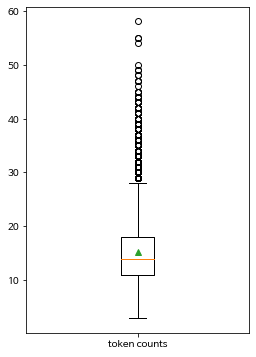

In [35]:
plt.figure(figsize=(4, 6))
plt.boxplot(train_question_counts, labels=['token counts'], showmeans=True)
plt.show()

### Q. 그래서 Question의 길이분포가 어떻다는 건가요?

- question 의 평균 길이는 15.25 이고 전체의 75%는 18 이내의 길이를 가집니다. 
- 이상치를 확인할 때 가장 많이 쓰는 방법은 그 값이 제 3사분위수와 제 1사분위수로부터 1.5xIQR(MAX) 보다 오른쪽에 있거나 왼쪽에 있는지를 확인하는 방법입니다. 
- question의 MAX 값은 28.5으로, 이 이상의 값은 (통계적)상한 이상치로 볼 수 있습니다. 
- 박스플롯에서 동그라미는 이상치를 나타냅니다.

## 5-2. 데이터 분석 : Context
- 위와 동일한 방법으로 context 항목에 대해서도 분석해봅니다.

In [36]:
train_context_counts = [len(context) for context in contexts]
train_context_counts[:10]

[278, 278, 278, 278, 278, 278, 278, 278, 209, 209]

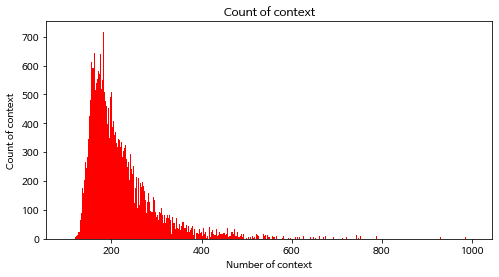

In [37]:
plt.figure(figsize=(8, 4))
plt.hist(train_context_counts, bins=900, range=[100, 1000], facecolor='r', label='train')
plt.title('Count of context')
plt.xlabel('Number of context')
plt.ylabel('Count of context')
plt.show()

In [38]:
print(f"context 길이 최대:    {np.max(train_context_counts):4d}")
print(f"context 길이 최소:    {np.min(train_context_counts):4d}")
print(f"context 길이 평균:    {np.mean(train_context_counts):7.2f}")
print(f"context 길이 표준편차: {np.std(train_context_counts):7.2f}")
percentile25 = np.percentile(train_context_counts, 25)
percentile50 = np.percentile(train_context_counts, 50)
percentile75 = np.percentile(train_context_counts, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"context 25/100분위:  {percentile25:7.2f}")
print(f"context 50/100분위:  {percentile50:7.2f}")
print(f"context 75/100분위:  {percentile75:7.2f}")
print(f"context IQR:        {percentileIQR:7.2f}")
print(f"context MAX/100분위: {percentileMAX:7.2f}")

context 길이 최대:    4816
context 길이 최소:     108
context 길이 평균:     222.84
context 길이 표준편차:   97.68
context 25/100분위:   169.00
context 50/100분위:   199.00
context 75/100분위:   248.00
context IQR:          79.00
context MAX/100분위:  366.50


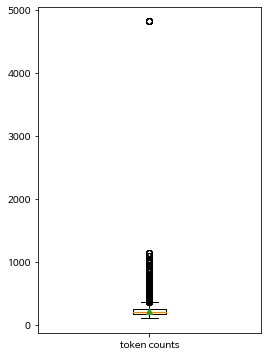

In [39]:
plt.figure(figsize=(4, 6))
plt.boxplot(train_context_counts, labels=['token counts'], showmeans=True)
plt.show()

### Q. 그래서 Context의 길이분포가 어떻다는 건가요?

- context 의 평균 길이는 222.84 이고 전체의 75%는 248 이내의 길이를 가집니다. 
- 이상치를 확인할 때 가장 많이 쓰는 방법은 그 값이 제 3사분위수와 제 1사분위수로부터 1.5xIQR(MAX) 보다 오른쪽에 있거나 왼쪽에 있는지를 확인하는 방법입니다. 
- question의 MAX 값은 366.5으로, 이 이상의 값은 (통계적)상한 이상치로 볼 수 있습니다. 
- 박스플롯에서 동그라미는 이상치를 나타냅니다.
- 박스플롯에서 유유히 혼자 표류하는 길이 약 5000 의 context가 눈에 띄네요. 데이터를 확인해봐야 할 듯합니다.  

## 5-3. 데이터 분석 : Answer
- 위와 동일한 방법으로 answer 항목에 대해서도 분석해봅니다.

In [40]:
train_answer_starts = token_starts
train_answer_starts[:10]

[19, 168, 80, 6, 143, 0, 165, 216, 164, 7]

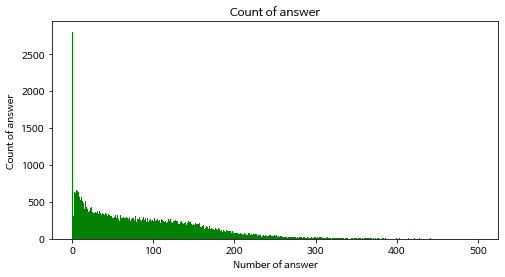

In [41]:
plt.figure(figsize=(8, 4))
plt.hist(train_answer_starts, bins=500, range=[0, 500], facecolor='g', label='train')
plt.title('Count of answer')
plt.xlabel('Number of answer')
plt.ylabel('Count of answer')
plt.show()

In [42]:
print(f"answer 위치 최대:    {np.max(train_answer_starts):4d}")
print(f"answer 위치 최소:    {np.min(train_answer_starts):4d}")
print(f"answer 위치 평균:    {np.mean(train_answer_starts):7.2f}")
print(f"answer 위치 표준편차: {np.std(train_answer_starts):7.2f}")
percentile25 = np.percentile(train_answer_starts, 25)
percentile50 = np.percentile(train_answer_starts, 50)
percentile75 = np.percentile(train_answer_starts, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"answer 25/100분위:  {percentile25:7.2f}")
print(f"answer 50/100분위:  {percentile50:7.2f}")
print(f"answer 75/100분위:  {percentile75:7.2f}")
print(f"answer IQR:        {percentileIQR:7.2f}")
print(f"answer MAX/100분위: {percentileMAX:7.2f}")

answer 위치 최대:    1124
answer 위치 최소:       0
answer 위치 평균:      89.01
answer 위치 표준편차:   78.21
answer 25/100분위:    25.00
answer 50/100분위:    74.00
answer 75/100분위:   134.00
answer IQR:         109.00
answer MAX/100분위:  297.50


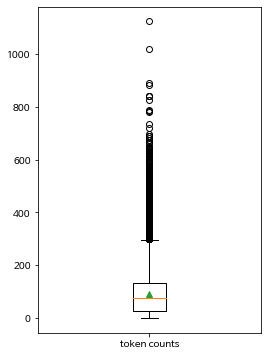

In [43]:
plt.figure(figsize=(4, 6))
plt.boxplot(train_answer_starts, labels=['token counts'], showmeans=True)
plt.show()

### Q. 그래서 Answer의 위치분포가 어떻다는 건가요?

- answer 의 평균 위치는 89.01 이고 전체의 75%는 134 이내의 위치를 가집니다. 
- 이상치를 확인할 때 가장 많이 쓰는 방법은 그 값이 제 3사분위수와 제 1사분위수로부터 1.5xIQR(MAX) 보다 오른쪽에 있거나 왼쪽에 있는지를 확인하는 방법입니다. 
- answer의 MAX 값은 297.5으로, 이 이상의 값은 상한 이상치로 볼 수 있습니다. 
- 박스플롯에서 동그라미는 이상치를 나타냅니다.

## 5-4. 데이터 분석 : Word Cloud
- 워드 클라우드(Word Cloud)란 자료의 빈도수를 시각화해서 나타내는 방법입니다. 
- 문서의 핵심 단어를 한눈에 파악할 수 있고, 빅데이터를 분석할 때 데이터의 특징을 도출하기 위해서 활용됩니다. 빈도수가 높은 단어일수록 글씨 크기가 큰 특징이 있습니다. 

In [44]:
# train documents
documents = []

# 전체 데이터에서 title, context, question 문장을 모두 추출합니다. 
for data in tqdm(train_json["data"]):
    title = data["title"]
    documents.append(title)
    for paragraph in data["paragraphs"]:
        context = paragraph["context"]
        documents.append(context)

        for qa in paragraph["qas"]:
            assert len(qa["answers"]) == 1
            question = qa["question"]
            documents.append(question)

documents[:10]   # 그중 맨 앞 10개만 확인해 봅니다.

  0%|          | 0/1420 [00:00<?, ?it/s]

['파우스트_서곡',
 '1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. 여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 볼 수 있다. 그렇게 교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에 중단했다. 또한 작품의 완성과 동시에 그는 이 서곡(1악장)을 파리 음악원의 연주회에서 연주할 파트보까지 준비하였으나, 실제로는 이루어지지는 않았다. 결국 초연은 4년 반이 지난 후에 드레스덴에서 연주되었고 재연도 이루어졌지만, 이후에 그대로 방치되고 말았다. 그 사이에 그는 리엔치와 방황하는 네덜란드인을 완성하고 탄호이저에도 착수하는 등 분주한 시간을 보냈는데, 그런 바쁜 생활이 이 곡을 잊게 한 것이 아닌가 하는 의견도 있다.',
 '바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?',
 '바그너는 교향곡 작곡을 어디까지 쓴 뒤에 중단했는가?',
 '바그너가 파우스트 서곡을 쓸 때 어떤 곡의 영향을 받았는가?',
 '1839년 바그너가 교향곡의 소재로 쓰려고 했던 책은?',
 '파우스트 서곡의 라단조 조성이 영향을 받은 베토벤의 곡은?',
 '바그너가 파우스트를 처음으로 읽은 년도는?',
 '바그너가 처음 교향곡 작곡을 한 장소는?',
 '바그너의 1악장의 초연은 어디서 연주되었는가?']

In [45]:
# documents를 전부 이어 하나의 문장으로 만들면 이렇게 보입니다. 
" ".join(documents[:10])

'파우스트_서곡 1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. 여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 볼 수 있다. 그렇게 교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에 중단했다. 또한 작품의 완성과 동시에 그는 이 서곡(1악장)을 파리 음악원의 연주회에서 연주할 파트보까지 준비하였으나, 실제로는 이루어지지는 않았다. 결국 초연은 4년 반이 지난 후에 드레스덴에서 연주되었고 재연도 이루어졌지만, 이후에 그대로 방치되고 말았다. 그 사이에 그는 리엔치와 방황하는 네덜란드인을 완성하고 탄호이저에도 착수하는 등 분주한 시간을 보냈는데, 그런 바쁜 생활이 이 곡을 잊게 한 것이 아닌가 하는 의견도 있다. 바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가? 바그너는 교향곡 작곡을 어디까지 쓴 뒤에 중단했는가? 바그너가 파우스트 서곡을 쓸 때 어떤 곡의 영향을 받았는가? 1839년 바그너가 교향곡의 소재로 쓰려고 했던 책은? 파우스트 서곡의 라단조 조성이 영향을 받은 베토벤의 곡은? 바그너가 파우스트를 처음으로 읽은 년도는? 바그너가 처음 교향곡 작곡을 한 장소는? 바그너의 1악장의 초연은 어디서 연주되었는가?'

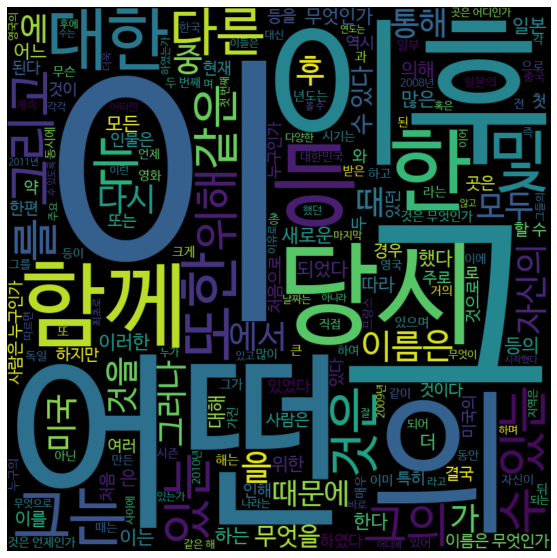

In [46]:
# WordCloud로 " ".join(documents)를 처리해 봅니다. 
wordcloud = WordCloud(width=800, height=800, font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf').generate(" ".join(documents))
plt.figure(figsize=(10, 10))
# image 출력, interpolation 이미지 시각화 옵션
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

- '이', '그' 가 가장 크고, 그다음으로 '어떤', '이후', '의' '당시'와 같은 단어가 크게 보입니다.
- 빈도 수 시각화 결과는 납득이 갑니다. 
- '이' '그' 는 여러 품사로 사용될 수 있는 중의적인 단어입니다. 예를 들어 '그'는 지시대명사이기도 하며 3인칭 대명사이기도 합니다. '이'는 지시대명사이기도 하면서, 조사이기도 합니다. 
- 이처럼 WordCloud를 활용하여 문서의 핵심단어를 시각화하여 직관적으로 문서를 파악할 수 있습니다.

## (6) 데이터 로드
- 지금까지 만든 데이터셋을 메모리에 로드합니다.

In [47]:
train_json = os.path.join(data_dir, "korquad_train.json")
dev_json = os.path.join(data_dir, "korquad_dev.json")

In [48]:
class Config(dict):
    """
    json을 config 형태로 사용하기 위한 Class
    :param dict: config dictionary
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__


args = Config({
    'max_seq_length': 384,
    'max_query_length': 64,
})
args

{'max_seq_length': 384, 'max_query_length': 64}

In [49]:
# 생성한 데이터셋 파일을 메모리에 로딩하는 함수
def load_data(args, filename):
    inputs, segments, labels_start, labels_end = [], [], [], []

    n_discard = 0
    with open(filename, "r") as f:
        for i, line in enumerate(tqdm(f, desc=f"Loading ...")):
            data = json.loads(line)
            token_start = data.get("token_start")
            token_end = data.get("token_end")
            question = data["question"][:args.max_query_length]
            context = data["context"]
            answer_tokens = " ".join(context[token_start:token_end + 1])
            context_len = args.max_seq_length - len(question) - 3

            if token_end >= context_len:
                # 최대 길이내에 token이 들어가지 않은 경우 처리하지 않음
                n_discard += 1
                continue
            context = context[:context_len]
            assert len(question) + len(context) <= args.max_seq_length - 3

            tokens = ['[CLS]'] + question + ['[SEP]'] + context + ['[SEP]']
            ids = [vocab.piece_to_id(token) for token in tokens]
            ids += [0] * (args.max_seq_length - len(ids))
            inputs.append(ids)
            segs = [0] * (len(question) + 2) + [1] * (len(context) + 1)
            segs += [0] * (args.max_seq_length - len(segs))
            segments.append(segs)
            token_start += (len(question) + 2)
            labels_start.append(token_start)
            token_end += (len(question) + 2)
            labels_end.append(token_end)
    print(f'n_discard: {n_discard}')

    return (np.array(inputs), np.array(segments)), (np.array(labels_start), np.array(labels_end))

In [50]:
# train data load
train_inputs, train_labels = load_data(args, train_json)
print(f"train_inputs: {train_inputs[0].shape}")
print(f"train_inputs: {train_inputs[1].shape}")
print(f"train_labels: {train_labels[0].shape}")
print(f"train_labels: {train_labels[1].shape}")

# dev data load
dev_inputs, dev_labels = load_data(args, dev_json)
print(f"dev_inputs: {dev_inputs[0].shape}")
print(f"dev_inputs: {dev_inputs[1].shape}")
print(f"dev_labels: {dev_labels[0].shape}")
print(f"dev_labels: {dev_labels[1].shape}")

train_inputs[:10], train_labels[:10]

Loading ...: 0it [00:00, ?it/s]

n_discard: 430
train_inputs: (59977, 384)
train_inputs: (59977, 384)
train_labels: (59977,)
train_labels: (59977,)


Loading ...: 0it [00:00, ?it/s]

n_discard: 78
dev_inputs: (5696, 384)
dev_inputs: (5696, 384)
dev_labels: (5696,)
dev_labels: (5696,)


((array([[    5, 15798,    10, ...,     0,     0,     0],
         [    5, 15798,    10, ...,     0,     0,     0],
         [    5, 15798,    19, ...,     0,     0,     0],
         ...,
         [    5, 21666,    19, ...,     0,     0,     0],
         [    5,   964, 16865, ...,     0,     0,     0],
         [    5,   365,    15, ...,     0,     0,     0]]),
  array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]])),
 (array([ 37, 184,  98, ...,  74, 190,  35]),
  array([ 37, 185, 102, ...,  75, 191,  44])))

In [51]:
# Question과 Context가 포함된 입력데이터 1번째
train_inputs[0][0]

array([    5, 15798,    10, 28935,     9,    11, 29566,    20, 14604,
       20424,  3904,    70,    11,  4648,    10,    19,  1910,     4,
       22070,    15, 15798,    10, 28935,     9,    11, 29566,    16,
         626, 14604,    38, 14028, 11773, 13829,   384,  8376,  3021,
        1239,  6874,    16,  1687,  5958,  2694,  5061,     7,    30,
        1613, 15798,    10, 28065,    75,  4415,  1816,  4978,    27,
         347,   145,   107,  2703,   263,    11,     1,    18,  5853,
          99,  9677,    24, 11969,    13,  7595,   437,  1019,  5907,
         257,  3794,  1972,    20, 11278,    11, 29566,     9,   612,
       12631, 13214,  1732,    76,     7,   110,  8802, 17581,   354,
        9648,  2060,    21,  1682, 22110, 18164,    17, 21076, 14980,
           9,  6874,    81, 11325,  4239,  3597,  1010,  1035, 17670,
           8,  2447,  1306,    35,   443,    11, 29566,     9,   315,
       12729, 14457,    30,  7938,  3742, 10766,   634,  9971, 17590,
       19424,    10,

In [52]:
# Question을 0으로, Context를 1로 구분해 준 Segment 데이터 1번째
train_inputs[1][0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,

In [53]:
# Answer위치의 시작점과 끝점 라벨 1번째
train_labels[0][0], train_labels[1][0]

(37, 37)

# Q3. 모델 학습은 어떻게 해야해?
- KorQuAD 태스크를 3가지 모델을 활용하여 학습해보고, 그 결과를 비교분석해보겠습니다. 
  1. LSTM 
  2. BERT
  3. BERT pretraind model

## (1) LSTM 적용
- 우선 KorQuAD 태스크를 LSTM 모델을 활용하여 학습해봅니다. 
- Input이 2개, Output이 2개인 모델입니다.
- 2개의 Input은 이전 스텝에서 보았던 train_inputs[0], train_inputs[1]이 들어갑니다. 이들은 각각 Question+Context의 데이터와 Segment입니다. 그리고 Output은 Answer의 시작점과 끝점의 위치입니다.

In [54]:
def build_model_lstm(n_vocab, n_seq, d_model):
    tokens = tf.keras.layers.Input((None,), name='tokens')
    segments = tf.keras.layers.Input((None,), name='segments')

    hidden = tf.keras.layers.Embedding(n_vocab, d_model)(tokens) + tf.keras.layers.Embedding(2, d_model)(segments) # (bs, n_seq, d_model)

    hidden = tf.keras.layers.LSTM(d_model, return_sequences=True)(hidden)  # (bs, n_seq, d_model)
    hidden = tf.keras.layers.LSTM(d_model, return_sequences=True)(hidden)  # (bs, n_seq, d_model)
    hidden = tf.keras.layers.Dense(2)(hidden) # (bs, n_seq, 2)
    start_logits, end_logits = tf.split(hidden, 2, axis=-1)  # (bs, n_seq, 1), (bs, n_seq, 1)
    start_logits = tf.squeeze(start_logits, axis=-1)  # (bs, n_seq)
    start_outputs = tf.keras.layers.Softmax(name="start")(start_logits)
    end_logits = tf.squeeze(end_logits, axis=-1)  # (bs, n_seq)
    end_outputs = tf.keras.layers.Softmax(name="end")(end_logits)

    model = tf.keras.Model(inputs=(tokens, segments), outputs=(start_outputs, end_outputs))
    return model

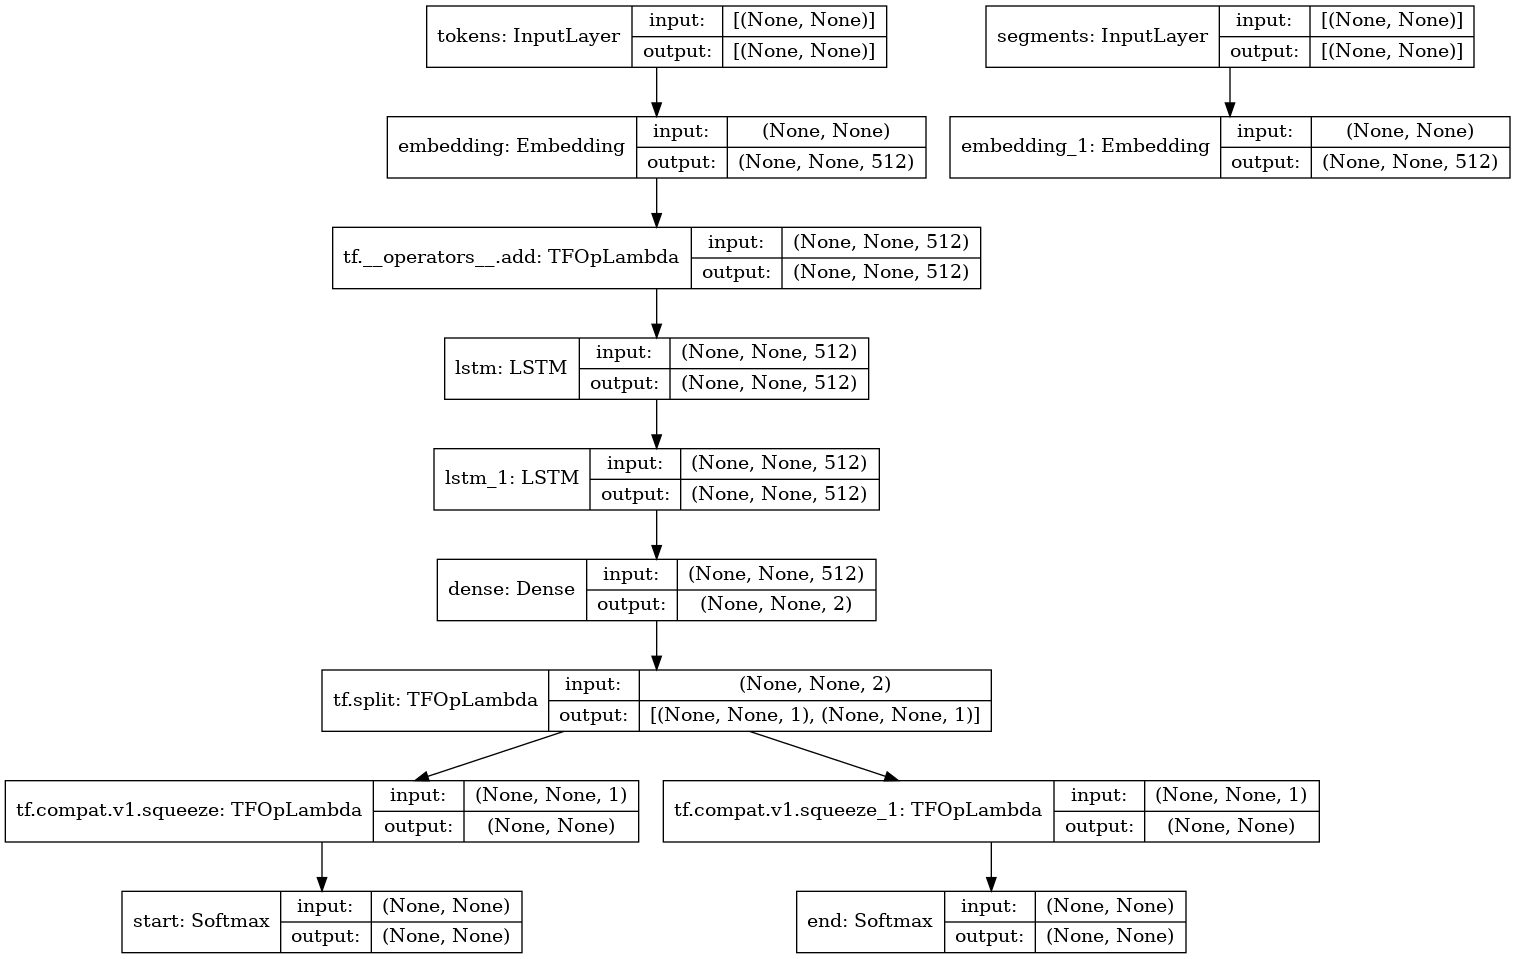

In [55]:
model = build_model_lstm(n_vocab=len(vocab), n_seq=512, d_model=512)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [56]:
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4), metrics=["accuracy"])

- 훈련에는 대략 1 epoch에 2~3분가량 소요됩니다.
- 시간관계상 20epoch만 돌려보겠습니다.
- 5 epochs 이상 val_start_accuracy가 좋아지지 않으면 훈련을 종료하도록 Early Stopping을 적용합니다.

In [57]:
# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_start_accuracy', patience=5)
# save weights
save_weights = tf.keras.callbacks.ModelCheckpoint(os.path.join(data_dir, "korquad_lstm.hdf5"), monitor='val_start_accuracy', verbose=1, save_best_only=True, mode='max', save_freq='epoch', save_weights_only=True)

history = model.fit(train_inputs, train_labels, epochs=20, batch_size=128, validation_data=(dev_inputs, dev_labels), callbacks=[early_stopping, save_weights])

Epoch 1/20
469/469 [==============================] - 494s 1s/step - loss: 10.0419 - start_loss: 4.9617 - end_loss: 5.0802 - start_accuracy: 0.0367 - end_accuracy: 0.0294 - val_loss: 8.2439 - val_start_loss: 3.9183 - val_end_loss: 4.3257 - val_start_accuracy: 0.0918 - val_end_accuracy: 0.0799

Epoch 00001: val_start_accuracy improved from -inf to 0.09182, saving model to /aiffel/aiffel/bert_qna/data/korquad_lstm.hdf5
Epoch 2/20
469/469 [==============================] - 496s 1s/step - loss: 7.2990 - start_loss: 3.4786 - end_loss: 3.8205 - start_accuracy: 0.1247 - end_accuracy: 0.1203 - val_loss: 8.1898 - val_start_loss: 3.8904 - val_end_loss: 4.2994 - val_start_accuracy: 0.0988 - val_end_accuracy: 0.0751

Epoch 00002: val_start_accuracy improved from 0.09182 to 0.09884, saving model to /aiffel/aiffel/bert_qna/data/korquad_lstm.hdf5
Epoch 3/20
469/469 [==============================] - 497s 1s/step - loss: 6.5859 - start_loss: 3.1612 - end_loss: 3.4247 - start_accuracy: 0.1628 - end_acc

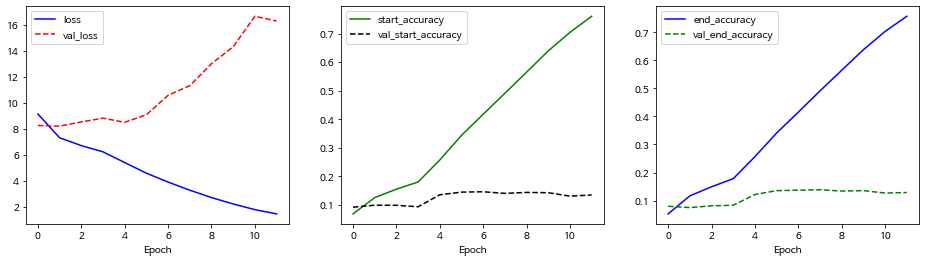

In [58]:
# training result
plt.figure(figsize=(16, 4))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['start_accuracy'], 'g-', label='start_accuracy')
plt.plot(history.history['val_start_accuracy'], 'k--', label='val_start_accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history.history['end_accuracy'], 'b-', label='end_accuracy')
plt.plot(history.history['val_end_accuracy'], 'g--', label='val_end_accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.show()

- LSTM모델을 활용한 학습결과, val_loss는 15 이하로 낮아지지 않고, val_accuracy는 0.1 수준에 머물고 있습니다. 

## (2) BERT

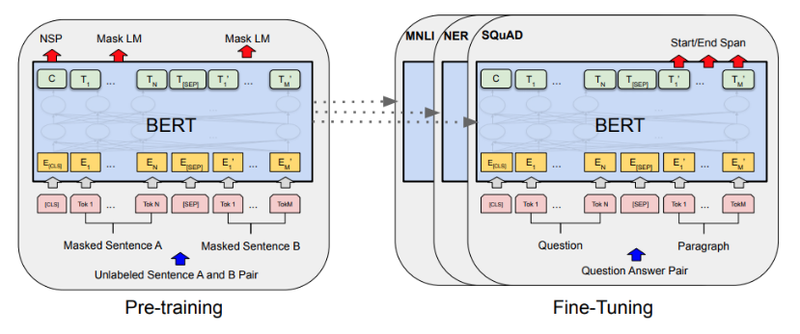

- Transformer 모델은 Self-Attention 으로 이루어진 Encoder-Decoder 구조를 가지고 있어서 번역기 모델 형태를 구현하는데 적당했습니다.
- BERT는 여기서 Transformer Encoder 구조만을 활용합니다. Layer 개수는 12개 이상으로 늘리고, 전체적으로 파라미터 크기가 훨씬 커지긴 했지만 기본적인 구조는 동일합니다.
- 그런데 Decoder가 없다면 이 모델은 어떻게 학습시키는 걸까요? 위 그림의 왼쪽을 보면 BERT의 입력을 Transformer Encoder에 넣었을 때, 출력 모델이 Mask LM, NSP 라는 2가지 문제를 해결하도록 되어 있습니다. 이들은 각각 다음과 같은 내용입니다.

#### Mask LM
입력 데이터가 나는 \<mask\> 먹었다 일 때 BERT 모델이 \<mask\>가 밥을 임을 맞출 수 있도록 하는 언어 모델입니다. 이전의 Next Token Prediction Language Model과 대비 시켜 이른바 **다음 빈칸에 알맞은 말은 문제**를 엄청나게 풀어보는 언어 모델을 구현한 것입니다.
    
#### Next Sentence Prediction 
이 경우는 입력데이터가 나는 밥을 먹었다. \<SEP\> 그래서 지금 배가 부르다.가 주어졌을 때 \<SEP\>를 경계로 **좌우 두 문장이 순서대로 이어지는 문장이 맞는지**를 맞추는 문제입니다. BERT 모델은 이 두 문장을 입력으로 받았을 때 첫 번째 바이트에 NSP 결과값을 리턴하게 됩니다.

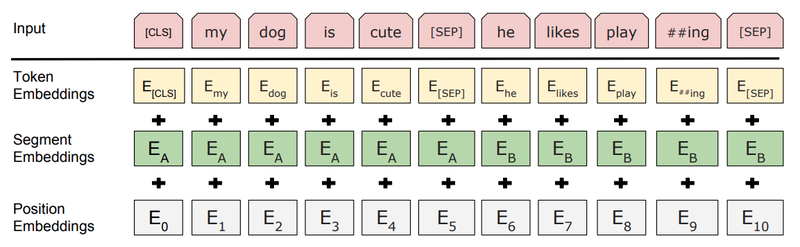

### BERT 모델의 입력에 주목!
- 텍스트 입력이 위 그림의 [Input]처럼 주어졌을 때, 실제로 모델에 입력되는 것은 Token, Segment, Position Embedding의 3가지가 더해진 형태입니다.
- 실제로는 그 이후 layer normalization과 dropout이 추가로 적용됩니다. 

#### Token Embedding
- BERT는 텍스트의 tokenizer로 Word Piece model이라는 subword tokenizer를 사용합니다. 
- 문자(char) 단위로 임베딩하는 것이 기본이지만, 자주 등장하는 긴 길이의 subword도 하나의 단위로 만들어 줍니다.
- 자주 등장하지 않는 단어는 다시 subword 단위로 쪼개집니다. 
- 이것은 자주 등장하지 않는 단어가 OOV(Out-of-vocabulary) 처리되는 것을 방지해 주는 장점도 있습니다. 그래서 최종적으로 Word Piece모델의 각 임베딩이 입력됩니다.

#### Segment Embedding
- 기존 Transformer에 없던 독특한 임베딩입니다
- 이것은 각 단어가 어느 문장에 포함되는지 그 역할을 규정하는 것입니다.
- 특히 QA 문제처럼 이 단어가 Question 문장에 속하는지, Context 문장에 속하는지 구분이 필요한 경우에 이 임베딩은 매우 유용하게 사용됩니다.


#### Position Embedding
- 이 임베딩은 기존의 Transformer에서 사용되던 position embedding과 동일합니다.

### 다음은 BERT를 구성하는 레이어입니다.

In [59]:
# 유틸리티 함수들

def get_pad_mask(tokens, i_pad=0):
    """
    pad mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: pad mask (pad: 1, other: 0)
    """
    mask = tf.cast(tf.math.equal(tokens, i_pad), tf.float32)
    mask = tf.expand_dims(mask, axis=1)
    return mask


def get_ahead_mask(tokens, i_pad=0):
    """
    ahead mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: ahead and pad mask (ahead or pad: 1, other: 0)
    """
    n_seq = tf.shape(tokens)[1]
    ahead_mask = 1 - tf.linalg.band_part(tf.ones((n_seq, n_seq)), -1, 0)
    ahead_mask = tf.expand_dims(ahead_mask, axis=0)
    pad_mask = get_pad_mask(tokens, i_pad)
    mask = tf.maximum(ahead_mask, pad_mask)
    return mask


@tf.function(experimental_relax_shapes=True)
def gelu(x):
    """
    gelu activation 함수
    :param x: 입력 값
    :return: gelu activation result
    """
    return 0.5 * x * (1 + K.tanh(x * 0.7978845608 * (1 + 0.044715 * x * x)))


def kernel_initializer(stddev=0.02):
    """
    parameter initializer 생성
    :param stddev: 생성할 랜덤 변수의 표준편차
    """
    return tf.keras.initializers.TruncatedNormal(stddev=stddev)


def bias_initializer():
    """
    bias initializer 생성
    """
    return tf.zeros_initializer


class Config(dict):
    """
    json을 config 형태로 사용하기 위한 Class
    :param dict: config dictionary
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        """
        file에서 Config를 생성 함
        :param file: filename
        """
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)

In [60]:
# mode == "embedding" 일 경우 Token Embedding Layer 로 사용되는 layer 클래스입니다. 

class SharedEmbedding(tf.keras.layers.Layer):
    """
    Weighed Shared Embedding Class
    """
    def __init__(self, config, name="weight_shared_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.n_vocab = config.n_vocab
        self.d_model = config.d_model
    
    def build(self, input_shape):
        """
        shared weight 생성
        :param input_shape: Tensor Shape (not used)
        """
        with tf.name_scope("shared_embedding_weight"):
            self.shared_weights = self.add_weight(
                "weights",
                shape=[self.n_vocab, self.d_model],
                initializer=kernel_initializer()
            )

    def call(self, inputs, mode="embedding"):
        """
        layer 실행
        :param inputs: 입력
        :param mode: 실행 모드
        :return: embedding or linear 실행 결과
        """
        # mode가 embedding일 경우 embedding lookup 실행
        if mode == "embedding":
            return self._embedding(inputs)
        # mode가 linear일 경우 linear 실행
        elif mode == "linear":
            return self._linear(inputs)
        # mode가 기타일 경우 오류 발생
        else:
            raise ValueError(f"mode {mode} is not valid.")
    
    def _embedding(self, inputs):
        """
        embedding lookup
        :param inputs: 입력
        """
        embed = tf.gather(self.shared_weights, tf.cast(inputs, tf.int32))
        return embed

    def _linear(self, inputs):  # (bs, n_seq, d_model)
        """
        linear 실행
        :param inputs: 입력
        """
        n_batch = tf.shape(inputs)[0]
        n_seq = tf.shape(inputs)[1]
        inputs = tf.reshape(inputs, [-1, self.d_model])  # (bs * n_seq, d_model)
        outputs = tf.matmul(inputs, self.shared_weights, transpose_b=True)
        outputs = tf.reshape(outputs, [n_batch, n_seq, self.n_vocab])  # (bs, n_seq, n_vocab)
        return outputs

In [61]:
class PositionalEmbedding(tf.keras.layers.Layer):
    """
    Positional Embedding Class
    """
    def __init__(self, config, name="position_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)
        
        self.embedding = tf.keras.layers.Embedding(config.n_seq, config.d_model, embeddings_initializer=kernel_initializer())

    def call(self, inputs):
        """
        layer 실행
        :param inputs: 입력
        :return embed: positional embedding lookup 결과
        """
        position = tf.cast(tf.math.cumsum(tf.ones_like(inputs), axis=1, exclusive=True), tf.int32)
        embed = self.embedding(position)
        return embed

In [62]:
class ScaleDotProductAttention(tf.keras.layers.Layer):
    """
    Scale Dot Product Attention Class
    """
    def __init__(self, name="scale_dot_product_attention"):
        """
        생성자
        :param name: layer name
        """
        super().__init__(name=name)

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        attn_score = tf.matmul(Q, K, transpose_b=True)
        scale = tf.math.sqrt(tf.cast(tf.shape(K)[-1], tf.float32))
        attn_scale = tf.math.divide(attn_score, scale)
        attn_scale -= 1.e9 * attn_mask
        attn_prob = tf.nn.softmax(attn_scale, axis=-1)
        attn_out = tf.matmul(attn_prob, V)
        return attn_out

In [63]:
class MultiHeadAttention(tf.keras.layers.Layer):
    """
    Multi Head Attention Class
    """
    def __init__(self, config, name="multi_head_attention"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.d_model = config.d_model
        self.n_head = config.n_head
        self.d_head = config.d_head

        # Q, K, V input dense layer
        self.W_Q = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_K = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_V = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        # Scale Dot Product Attention class
        self.attention = ScaleDotProductAttention(name="self_attention")
        # output dense layer
        self.W_O = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        # reshape Q, K, V, attn_mask
        batch_size = tf.shape(Q)[0]
        Q_m = tf.transpose(tf.reshape(self.W_Q(Q), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, Q_len, d_head)
        K_m = tf.transpose(tf.reshape(self.W_K(K), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        V_m = tf.transpose(tf.reshape(self.W_V(V), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        attn_mask_m = tf.expand_dims(attn_mask, axis=1)
        # Scale Dot Product Attention with multi head Q, K, V, attn_mask
        attn_out = self.attention(Q_m, K_m, V_m, attn_mask_m)  # (bs, n_head, Q_len, d_head)
        # transpose and liner
        attn_out_m = tf.transpose(attn_out, perm=[0, 2, 1, 3])  # (bs, Q_len, n_head, d_head)
        attn_out = tf.reshape(attn_out_m, [batch_size, -1, config.n_head * config.d_head])  # (bs, Q_len, d_model)
        attn_out = self.W_O(attn_out) # (bs, Q_len, d_model)

        return attn_out

In [64]:
class PositionWiseFeedForward(tf.keras.layers.Layer):
    """
    Position Wise Feed Forward Class
    """
    def __init__(self, config, name="feed_forward"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.W_1 = tf.keras.layers.Dense(config.d_ff, activation=gelu, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_2 = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, inputs):
        """
        layer 실행
        :param inputs: inputs
        :return ff_val: feed forward 실행 결과
        """
        ff_val = self.W_2(self.W_1(inputs))
        return ff_val

In [65]:
class EncoderLayer(tf.keras.layers.Layer):
    """
    Encoder Layer Class
    """
    def __init__(self, config, name="encoder_layer"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.self_attention = MultiHeadAttention(config)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.ffn = PositionWiseFeedForward(config)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.dropout = tf.keras.layers.Dropout(config.dropout)
 
    def call(self, enc_embed, self_mask):
        """
        layer 실행
        :param enc_embed: enc_embed 또는 이전 EncoderLayer의 출력
        :param self_mask: enc_tokens의 pad mask
        :return enc_out: EncoderLayer 실행 결과
        """
        self_attn_val = self.self_attention(enc_embed, enc_embed, enc_embed, self_mask)
        norm1_val = self.norm1(enc_embed + self.dropout(self_attn_val))

        ffn_val = self.ffn(norm1_val)
        enc_out = self.norm2(norm1_val + self.dropout(ffn_val))

        return enc_out

### BERT 모델 구현

In [66]:
class BERT(tf.keras.layers.Layer):
    """
    BERT Class
    """
    def __init__(self, config, name="bert"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.i_pad = config.i_pad
        self.embedding = SharedEmbedding(config)
        self.position = PositionalEmbedding(config)
        self.segment = tf.keras.layers.Embedding(2, config.d_model, embeddings_initializer=kernel_initializer())
        self.norm = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)
        
        self.encoder_layers = [EncoderLayer(config, name=f"encoder_layer_{i}") for i in range(config.n_layer)]

        self.dropout = tf.keras.layers.Dropout(config.dropout)

    def call(self, enc_tokens, segments):
        """
        layer 실행
        :param enc_tokens: encoder tokens
        :param segments: token segments
        :return logits_cls: CLS 결과 logits
        :return logits_lm: LM 결과 logits
        """
        enc_self_mask = get_pad_mask(enc_tokens, self.i_pad)

        enc_embed = self.get_embedding(enc_tokens, segments)

        enc_out = self.dropout(enc_embed)
        for encoder_layer in self.encoder_layers:
            enc_out = encoder_layer(enc_out, enc_self_mask)

        logits_cls = enc_out[:,0]
        logits_lm = enc_out
        return logits_cls, logits_lm
    
    def get_embedding(self, tokens, segments):
        """
        token embedding, position embedding lookup
        :param tokens: 입력 tokens
        :param segments: 입력 segments
        :return embed: embedding 결과
        """
        embed = self.embedding(tokens) + self.position(tokens) + self.segment(segments)
        embed = self.norm(embed)
        return embed

- BERT 모델을 활용하여, LSTM으로 풀어보았던 KorQuAD 태스크를 학습해봅니다. 
- 모델의 차이만 비교해보기 위해 두 모델이 사용하는 Tokenizer를 동일하게 구성했습니다. 

- 아래는 **BERT 레이어에 Fully Connected layer를 붙여 KorQuAD 용으로 finetune 하기 위한 모델 클래스** 입니다.

In [67]:
class BERT4KorQuAD(tf.keras.Model):
    def __init__(self, config):
        super().__init__(name='BERT4KorQuAD')

        self.bert = BERT(config)
        self.dense = tf.keras.layers.Dense(2)
    
    def call(self, enc_tokens, segments):
        logits_cls, logits_lm = self.bert(enc_tokens, segments)

        hidden = self.dense(logits_lm) # (bs, n_seq, 2)
        start_logits, end_logits = tf.split(hidden, 2, axis=-1)  # (bs, n_seq, 1), (bs, n_seq, 1)

        start_logits = tf.squeeze(start_logits, axis=-1)
        start_outputs = tf.keras.layers.Softmax(name="start")(start_logits)

        end_logits = tf.squeeze(end_logits, axis=-1)
        end_outputs = tf.keras.layers.Softmax(name="end")(end_logits)

        return start_outputs, end_outputs

In [68]:
config = Config({"d_model": 512, "n_head": 8, "d_head": 64, "dropout": 0.1, "d_ff": 1024, "layernorm_epsilon": 0.001, "n_layer": 6, "n_seq": 384, "n_vocab": 0, "i_pad": 0})
config.n_vocab = len(vocab)
config.i_pad = vocab.pad_id()
config

{'d_model': 512,
 'n_head': 8,
 'd_head': 64,
 'dropout': 0.1,
 'd_ff': 1024,
 'layernorm_epsilon': 0.001,
 'n_layer': 6,
 'n_seq': 384,
 'n_vocab': 32007,
 'i_pad': 0}

- Config을 통해 실제로 우리가 사용할 모델 사이즈를 조정하게 됩니다.
- BERT 논문에 공개된 실제 사이즈는 아래와 같습니다. 


    - BERT-base(110M parameters) : 12-layer, 768-hidden, 12-heads
    - BERT-large (336M parameters) : 24-layer, 1024-hidden, 16-heads

- 그러나 이처럼 거대한 모델을 작은 실습환경에서 다루기에는 무리가 있기 때문에, 사이즈를 아래와 같이 조정해봅니다. 
- **Our Tiny Bert(29M parameters) : 6-layer, 512-hidden, 8-heads**
- 모델의 크기가 다르고, 사용할 수 있는 배치 사이즈가 달라지므로, 배치 구성을 조정합니다.

In [69]:
bert_batch_size = 16 

train_dataset = tf.data.Dataset.from_tensor_slices((train_inputs, train_labels)).shuffle(10000).batch(bert_batch_size)
dev_dataset = tf.data.Dataset.from_tensor_slices((dev_inputs, dev_labels)).batch(bert_batch_size)

In [70]:
model = BERT4KorQuAD(config)

In [71]:
def train_epoch(model, dataset, loss_fn, acc_fn, optimizer):
    metric_start_loss = tf.keras.metrics.Mean(name='start_loss')
    metric_end_loss = tf.keras.metrics.Mean(name='end_loss')
    metric_start_acc = tf.keras.metrics.Mean(name='start_acc')
    metric_end_acc = tf.keras.metrics.Mean(name='end_acc')

    p_bar = tqdm(dataset)
    for batch, ((enc_tokens, segments), (start_labels, end_labels)) in enumerate(p_bar):
        with tf.GradientTape() as tape:
            start_outputs, end_outputs = model(enc_tokens, segments)

            start_loss = loss_fn(start_labels, start_outputs)
            end_loss = loss_fn(end_labels, end_outputs)
            loss = start_loss + end_loss

            start_acc = acc_fn(start_labels, start_outputs)
            end_acc = acc_fn(end_labels, end_outputs)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        metric_start_loss(start_loss)
        metric_end_loss(end_loss)
        metric_start_acc(start_acc)
        metric_end_acc(end_acc)
        if batch % 10 == 9:
            p_bar.set_description(f'loss: {metric_start_loss.result():0.4f}, {metric_end_loss.result():0.4f}, acc: {metric_start_acc.result():0.4f}, {metric_end_acc.result():0.4f}')
    p_bar.close()

    return metric_start_loss.result(), metric_end_loss.result(), metric_start_acc.result(), metric_end_acc.result()

In [72]:
def eval_epoch(model, dataset, loss_fn, acc_fn):
    metric_start_loss = tf.keras.metrics.Mean(name='start_loss')
    metric_end_loss = tf.keras.metrics.Mean(name='end_loss')
    metric_start_acc = tf.keras.metrics.Mean(name='start_acc')
    metric_end_acc = tf.keras.metrics.Mean(name='end_acc')

    for batch, ((enc_tokens, segments), (start_labels, end_labels)) in enumerate(dataset):
        start_outputs, end_outputs = model(enc_tokens, segments)

        start_loss = loss_fn(start_labels, start_outputs)
        end_loss = loss_fn(end_labels, end_outputs)

        start_acc = acc_fn(start_labels, start_outputs)
        end_acc = acc_fn(end_labels, end_outputs)

        metric_start_loss(start_loss)
        metric_end_loss(end_loss)
        metric_start_acc(start_acc)
        metric_end_acc(end_acc)

    return metric_start_loss.result(), metric_end_loss.result(), metric_start_acc.result(), metric_end_acc.result()

In [73]:
loss_fn = tf.keras.losses.sparse_categorical_crossentropy
acc_fn = tf.keras.metrics.sparse_categorical_accuracy

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)

best_acc = .0
patience = 0
for epoch in range(20):
    train_epoch(model, train_dataset, loss_fn, acc_fn, optimizer)
    start_loss, end_loss, start_acc, end_acc = eval_epoch(model, dev_dataset, loss_fn, acc_fn)
    print(f'eval {epoch} >> loss: {start_loss:0.4f}, {end_loss:0.4f}, acc: {start_acc:0.4f}, {end_acc:0.4f}')
    acc = start_acc + end_acc
    if best_acc < acc:
        patience = 0
        best_acc = acc
        model.save_weights(os.path.join(data_dir, "korquad_bert_none_pretrain.hdf5"))
        print(f'save best model')
    else:
        patience += 1
    if 5 <= patience:
        print(f'early stopping')
        break

  0%|          | 0/3749 [00:00<?, ?it/s]

eval 0 >> loss: 5.9507, 5.9507, acc: 0.0032, 0.0026
save best model


  0%|          | 0/3749 [00:00<?, ?it/s]

eval 1 >> loss: 5.9507, 5.9507, acc: 0.0040, 0.0053
save best model


  0%|          | 0/3749 [00:00<?, ?it/s]

eval 2 >> loss: 5.9507, 5.9507, acc: 0.0046, 0.0039


  0%|          | 0/3749 [00:00<?, ?it/s]

eval 3 >> loss: 5.9507, 5.9507, acc: 0.0044, 0.0042


  0%|          | 0/3749 [00:00<?, ?it/s]

eval 4 >> loss: 5.9507, 5.9507, acc: 0.0040, 0.0009


  0%|          | 0/3749 [00:00<?, ?it/s]

eval 5 >> loss: 5.9507, 5.9507, acc: 0.0023, 0.0023


  0%|          | 0/3749 [00:00<?, ?it/s]

eval 6 >> loss: 5.9507, 5.9507, acc: 0.0032, 0.0025
early stopping


- 우리의 BERT 모델에는 수많은 코퍼스를 통해 정교하게 얻어진 Word Embedding이 반영되지 않았기 때문에, LSTM 모델학습과 큰 차이가 없어보입니다. 그렇다면 pretrained model을 활용하여 finetuning했을 때의 결과는 어떨까요?




# (3) BERT Pretrained Model 

In [74]:
checkpoint_file = os.path.join(model_dir, 'bert_pretrain_32000.hdf5')

model = BERT4KorQuAD(config)

if os.path.exists(checkpoint_file):
    #  pretrained model 을 로드하기 위해 먼저 모델이 생성되어 있어야 한다.
    enc_tokens = np.random.randint(0, len(vocab), (4, 10))
    segments = np.random.randint(0, 2, (4, 10))
    model(enc_tokens, segments)
    
    # checkpoint 파일로부터 필요한 layer를 불러온다. 
    model.load_weights(os.path.join(model_dir, "bert_pretrain_32000.hdf5"), by_name=True)

    model.summary()
else:
    print('NO Pretrained Model')

Model: "BERT4KorQuAD"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (BERT)                  multiple                  29202944  
_________________________________________________________________
dense_74 (Dense)             multiple                  1026      
Total params: 29,203,970
Trainable params: 29,203,970
Non-trainable params: 0
_________________________________________________________________


## BERT pretrained model finetune 


In [75]:
loss_fn = tf.keras.losses.sparse_categorical_crossentropy
acc_fn = tf.keras.metrics.sparse_categorical_accuracy

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)

best_acc = .0
patience = 0
for epoch in range(20):
    train_epoch(model, train_dataset, loss_fn, acc_fn, optimizer)
    start_loss, end_loss, start_acc, end_acc = eval_epoch(model, dev_dataset, loss_fn, acc_fn)
    print(f'eval {epoch} >> loss: {start_loss:0.4f}, {end_loss:0.4f}, acc: {start_acc:0.4f}, {end_acc:0.4f}')
    acc = start_acc + end_acc
    if best_acc < acc:
        patience = 0
        best_acc = acc
        model.save_weights(os.path.join(data_dir, "korquad_bert_pretrain.hdf5"))
        print(f'save best model')
    else:
        patience += 1
    if 5 <= patience:
        print(f'early stopping')
        break

  0%|          | 0/3749 [00:00<?, ?it/s]

eval 0 >> loss: 2.0146, 2.3126, acc: 0.4824, 0.4350
save best model


  0%|          | 0/3749 [00:00<?, ?it/s]

eval 1 >> loss: 1.8459, 2.1088, acc: 0.5265, 0.4868
save best model


  0%|          | 0/3749 [00:00<?, ?it/s]

eval 2 >> loss: 2.0052, 2.4167, acc: 0.5351, 0.4898
save best model


  0%|          | 0/3749 [00:00<?, ?it/s]

eval 3 >> loss: 2.2147, 2.4017, acc: 0.5348, 0.4968
save best model


  0%|          | 0/3749 [00:00<?, ?it/s]

eval 4 >> loss: 2.1555, 2.4711, acc: 0.5279, 0.4744


  0%|          | 0/3749 [00:00<?, ?it/s]

eval 5 >> loss: 2.2877, 2.7319, acc: 0.5291, 0.4745


  0%|          | 0/3749 [00:00<?, ?it/s]

eval 6 >> loss: 2.3313, 2.6375, acc: 0.5105, 0.4654


  0%|          | 0/3749 [00:00<?, ?it/s]

eval 7 >> loss: 2.8979, 3.3460, acc: 0.5139, 0.4638


  0%|          | 0/3749 [00:00<?, ?it/s]

eval 8 >> loss: 3.0469, 3.5342, acc: 0.5097, 0.4573
early stopping


# pretrained BERT Inference
- pretrained BERT 모델이 얼마나 퀴즈를 잘 맞추는지 볼까요?
- pretrained BERT로 학습시킨 모델의 평가셋에 대한 추론결과와 실제정답을 비교해봅니다. 


In [76]:
def do_predict(model, question, context):
    """
    입력에 대한 답변 생성하는 함수
    :param model: model
    :param question: 입력 문자열
    :param context: 입력 문자열
    """
    q_tokens = vocab.encode_as_pieces(question)[:args.max_query_length]
    c_tokens = vocab.encode_as_pieces(context)[:args.max_seq_length - len(q_tokens) - 3]
    tokens = ['[CLS]'] + q_tokens + ['[SEP]'] + c_tokens + ['[SEP]']
    token_ids = [vocab.piece_to_id(token) for token in tokens]
    segments = [0] * (len(q_tokens) + 2) + [1] * (len(c_tokens) + 1)

    y_start, y_end = model(np.array([token_ids]), np.array([segments]))
    # print(y_start, y_end)
    y_start_idx = K.argmax(y_start, axis=-1)[0].numpy()
    y_end_idx = K.argmax(y_end, axis=-1)[0].numpy()
    answer_tokens = tokens[y_start_idx:y_end_idx + 1]

    return vocab.decode_pieces(answer_tokens)

In [ ]:
dev_json = os.path.join(data_dir, "korquad_dev.json")

with open(dev_json) as f:
    for i, line in enumerate(f):
        data = json.loads(line)
        question = vocab.decode_pieces(data['question'])
        context = vocab.decode_pieces(data['context'])
        answer = data['answer']
        answer_predict = do_predict(model, question, context)
        if answer in answer_predict:
            print(i)
            print("질문 : ", question)
            print("지문 : ", context)
            print("정답 : ", answer)
            print("예측 : ", answer_predict, "\n")
        if 100 < i:
            break

- 위 코드 출력 예시입니다. (깃허브 용량)
```
0
질문 :  임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배 된 날은?
지문 :  1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내려오는 임종석을 발견, 검거해 구속을 집행했다. 임종석은 청량리경찰서에서 약 1시간 동안 조사를 받은 뒤 오전 9시 50분 경 서울 장안동의 서울지방경찰청 공안분실로 인계되었다.
정답 :  1989년 2월 15일
예측 :  1989년 2월 15일 
```

- 46개의 평가문제 중 19개의 오류가 있었습니다.
- 추론오류를 살펴본 결과, 너그러운 인간이 채점한다면 세모정도의 점수는 줄만한 대답이었습니다.
- 오류의 경우에도 context에서 질문에 대한 대답이 있을만한 부분을 잘 찾아냈기 때문에 핵심단어가 포함되어 있습니다. 
- 추론오류의 유형은 다음과 같이 크게 3가지로 나눌 수 있습니다.
    - TMI : 문제에서 요구하는 답 이상의 정보를 가져옴(관련도 높음)
    - 조사 : '은, 는, 이, 가, 의' 등의 조사를 분류해내지 못함 
    - 문장부호 : '",:.() 등의 문장부호를 분류해내지 못함

|문제|정답|예측|오류 유형|
|--|--|--|--|
|국무회의의 심의를 거쳐야 한다는 헌법 제 몇 조의 내용인가?|제89조|'국무회의의 심의를 거쳐야 한다'(제89조)는|TMI, 조사|
|알렉산더 헤이그와 1950년 5월 결혼한 상대의 이름은 무엇인가?|퍼트리샤 앤토이넷 폭스|알론조 폭스 장군의 딸 퍼트리샤 앤토이넷 폭스 |TMI
|알렉산더 헤이그는 퍼트리샤 앤토이넷 폭스와 결혼해 몇 명의 자녀를 두었는가?|3명|3명의|조사|
|알렉산더 헤이그는 레이건의 조언자들을 무엇이라고 묘사하였는가?|외교 정책의 아마추어|"외교 정책의 아마추어"로|문장부호, 조사|
|하나님의 명령에 배를 만들고 가족과 짐승들을 배에 태워 홍수를 피한 사람은 누구인가?|노아|노아는 하나님의 명령에 따라 배를 만들고 가족과 정결한 짐승 암수 일곱 마리씩, 부정한 짐승 암수 한 마리씩|TMI|
|노아의 방주는 몇층으로 구성되어 있었는가?|3층|45~46cm를 가리킴), 상 ·중 ·하 3층으로|TMI,조사|
|제칠일안식교에서 비롯된 의사과학의 한 종류인 유사지질학의 이름은 무엇인가?|홍수지질학|홍수지질학과|조사|
|임종석이 1989년 2월 15일에 지명수배 받은 혐의는 어떤 시위를 주도했다는 것인가?|여의도 농민 폭력 시위|여의도 농민 폭력 시위를 주도한 혐의|TMI|
|법무부 장관을 제쳐놓고 민정수석이 개정안을 설명하는 게 이해가 안 된다고 지적한 경희대 석좌교수 이름은?|허영|허영 경희대 석좌교수는 정부의 헌법개정안 준비 과정에 대해 "청와대 비서실이 아닌 국무회의 중심으로 이뤄졌어야 했다"고 지적했다. '국무회의의 심의를 거쳐야 한다'(제89조)는 헌법 규정에 충실하지 않았다는 것이다. 그러면서 "법무부|TMI|

### Q. 왜 이런 오류가 발생할까?
- 이번 프로젝트는 형태소분석기가 아닌 SentencePiece로 한글텍스트를 tokenize 했습니다.
- 즉, 형태소 단위가 아닌 통계적 수치를 기반으로 단어를 토큰화 한 것입니다.
- 따라서 조사에 붙은 해당 단어가 데이터셋 내에 희박하다면, (조사를 독립적인 토큰으로 분류하는 것이 아니라) 조사까지 하나의 토큰으로 간주할 가능성이 높아진다고 예상할 수 있습니다.
- 위 추론평가 결과, 특정 사건이 발생한 년월일를 물어보는 질문에 대한 정답률이 가장 높았습니다. 특정 년월일은 보통 부사로 사용되어 복잡한 수식관계에 얽매이지 않습니다.  
- 반면 TMI 오류의 경우, "' 어떠어떠한' 사람 또는 이름은 무엇인가?'"라는 질문에서 명사에 대한 수식어('어떠어떠한')와 명사(사람 또는 이름)를 잘 구분해내지 못한다고 생각됩니다. 모델이 정답을 추출해내는 context에는 "'명사'는 '어떠어떠한' 또는 '어떠어떠하다'"의 구조로 쓰여져 있기 때문입니다.
- 질문에서 요구하는 답안이 명사라는 사실은 파악했지만, 한국어의 복잡한 수식관계의 늪에 빠져버린 것으로 추측할 수 있습니다.
- 형태소 분석기를 사용하면 오류가 (조금이라도) 해결될 수 있지 않을까 생각해봅니다.

# Q4. 모델 학습 결과는 어떻게 비교해?
- BERT 모델과 pretrained BERT 모델의 학습 경과를 시각화하여 비교분석 해보겠습니다.
- 모델 학습 시 미리 준비하지 않은 자는.. 고민끝에.. 모델을 다시 학습시킬 수는 없어 가내수공업을 진행했습니다. 

In [80]:
import pandas as pd

BERT = pd.DataFrame()
BERT['start_loss'] = [5.9507,5.9507,5.9507,5.9507,5.9507,5.9507,5.9507 ]
BERT['end_loss'] = [5.9507, 5.9507,5.9507,5.9507,5.9507,5.9507,5.9507]
BERT['start_acc'] = [0.0032,0.0040,0.0046,0.0044,0.0040,0.0023,0.0032 ]
BERT['end_acc'] = [0.0026, 0.0053,0.0039,0.0042,0.0009,0.0023,0.0025]

pre_BERT = pd.DataFrame()
pre_BERT['start_loss'] = [2.0146, 1.8459, 2.0052, 2.2147, 2.1555, 2.2877, 2.3313, 2.8979, 3.0469]
pre_BERT['end_loss'] = [2.3126, 2.1088, 2.4167, 2.4017, 2.4711, 2.7319, 2.6375, 3.3460, 3.5342]
pre_BERT['start_acc'] = [0.4824, 0.5265, 0.5351, 0.5348, 0.5279, 0.5291, 0.5105, 0.5139, 0.5097]
pre_BERT['end_acc'] = [0.4350, 0.4868, 0.4898, 0.4968, 0.4744, 0.4745, 0.4654, 0.4638, 0.4573]

In [107]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = ['start_loss', 'end_loss']
acc = ['start_acc','end_acc']

def compare_BERTs(df1, df2, type = 'All'):
    fig = plt.figure(figsize=(18,6))
    ax1 = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2)
    ax1.set_title(f'BERT model ({type})',size=20, pad=20); ax2.set_title(f'BERT pretrained model ({type})',size=20, pad=20)
    ax1.set_xlabel('epochs',size=15);ax2.set_xlabel('epochs',size=15)
    ax1.set_ylabel('value',size=15);ax2.set_ylabel('value',size=15)
    df1.plot(ax=ax1);df2.plot(ax=ax2)
    plt.show()

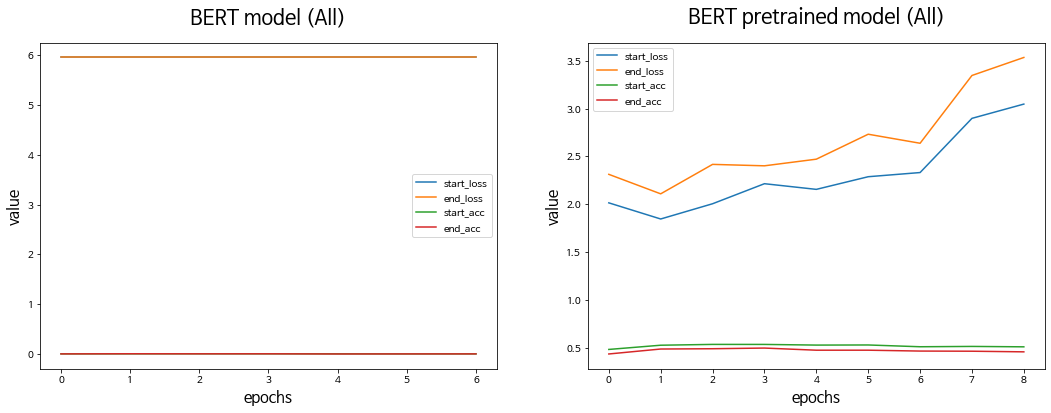

In [108]:
compare_BERTs(BERT, pre_BERT)

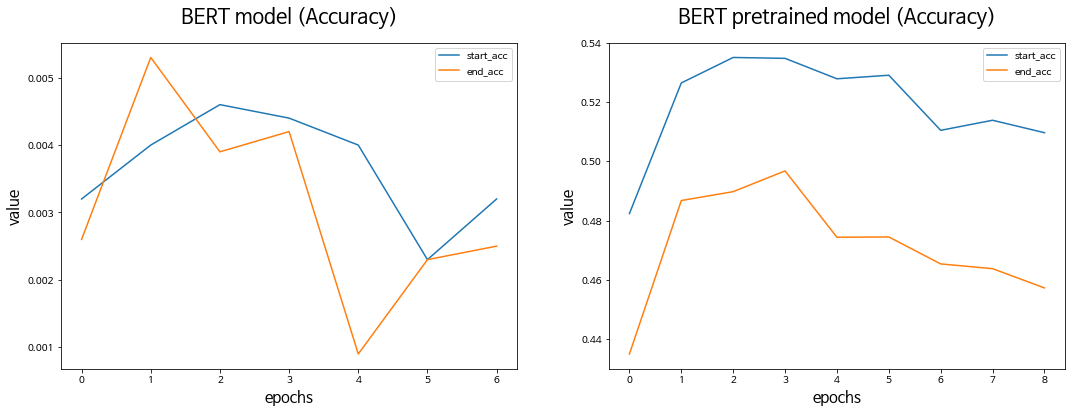

In [109]:
compare_BERTs(BERT[acc],pre_BERT[acc],'Accuracy')

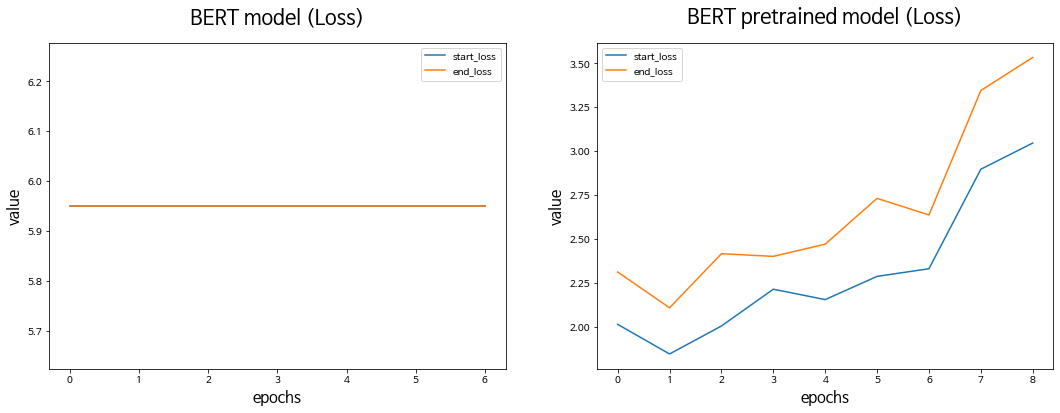

In [110]:
compare_BERTs(BERT[loss],pre_BERT[loss], 'Loss')

- BERT, pretrained BERT 는 각 epoch 6, 8에서 early stopped 되었습니다. 
- 사전학습되지 않은 BERT 모델은 val_acc(약 0.003)와 val_loss(약 6)의 성능향상이 거의 0에 수렴함을 확인할 수 있습니다.
- pretrained BERT 모델의 경우 val_acc(약 0.5)는 조금 상승하는듯 하다가 조금 하락합니다. val_loss(약 3)는 증가하는 모습을 보입니다..
- (기억하시나요? LSTM모델의 경우, val_loss는 15 이하로 낮아지지 않고, val_accuracy는 0.1 수준에 머물고 있었습니다.)
- 두 모델 모두 시간관계상 BERT 모델의 추천 하이퍼파라미터 사이즈의 1/2 으로 학습했다는 것을 고려하면, pretrained model의 훈련 결과는 썩 나쁘지만은 않은 것 같습니다. 
- 역시 pretrained BERT 모델이 사전학습하지 않은 BERT 모델보다 성능이 좋다는 것을 확인할 수 있었습니다. 
- 추천 모델 사이즈로 학습시켜보고 싶지만, 시간과 장비가 마땅치 않기 때문에 이정도로 만족하려 합니다. 
- pretrained BERT 모델의 추론평가 오류를 분석해본 결과,형태소분석기를 활용하여 데이터전처리 후 학습하면 성능이 향상될 것으로 예상됩니다. 

|평가문항|상세기준|
|----|----|
|1. BERT pretrained model을 활용한 KorQuAD 모델이 정상적으로 학습이 진행되었다.|KorQuAD 모델의 validation accuracy가 안정적으로 증가하였다.|
|2. KorQuAD Inference 결과가 원래의 정답과 비교하여 유사하게 나오는 것을 확인하였다.|평가셋에 대해 모델 추론 결과와 실제 정답의 유사성이 확인되었다.|
|3. pretrained model 활용이 효과적임을 실험을 통해 확인하였다.|pretrained model을 사용하지 않았을 때 대비 학습경과의 차이를 시각화를 통해 확인하였다.|
